In [2]:
###Folders

Input_folder = 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/'
Output_folder = 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Results/Ephys/'


'Download data from:  https://doi.org/10.17605/OSF.IO/3D9R2'

'Download data from:  https://doi.org/10.17605/OSF.IO/3D9R2'

In [93]:
##Importing libraries
from joblib import dump, load
import os, sys, pickle, time, re, csv
from collections import defaultdict#

import numpy as np
import pandas as pd

import scipy.stats as st
import math

import matplotlib.pyplot as plt
import seaborn as sns
import collections, numpy

from itertools import groupby
from collections import Counter
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from scipy.stats import circmean
from scipy.ndimage import gaussian_filter1d
import warnings
import scipy as sp
from scipy import stats

In [4]:
from collections import defaultdict
def rec_dd():
    return defaultdict(rec_dd)

def remove_empty(xx):

    yy= [x for x in xx if len(x) > 0]
    return(yy)

def random_rotation(length_array,angle_changes,sigma=10,noise_centre=5):
    rand_rotation=angle_changes[np.random.randint(0,len(angle_changes),size=length_array)]
    noise=np.random.normal(noise_centre,sigma,length_array) ##note, this is set to 5
    ##to make it equally likely to fall behind or ahead of cardinal axis when binned at 10 degree bins
    ##can just set to bin length/2
    return((rand_rotation+noise) % 360)

##convert nested dict into array
def dict_to_array(d):
    dictlist=[]
    for key, value in d.items():
        dictlist.append(value)
    return(np.asarray(dictlist))

##allows stacking two columns and removes rows containing nans/infs/-infs
def column_stack_clean(x,y):
    xy=np.column_stack((x,y))
    xy=xy[~np.isnan(xy).any(axis=1)]
    xy=xy[~np.isinf(xy).any(axis=1)]
    x=xy[:,0]
    y=xy[:,1]
    xy_new=np.column_stack((x,y))
    return(xy_new)

def rank_repeat(a):
    arr=np.zeros(len(a))
    for n in np.unique(a):
        count=0
        for ii in range(len(a)):
            if a[ii]==n:
                arr[ii]=count
                count+=1

    arr=arr.astype(int)
    return(arr)


##Defining Task grid
from scipy.spatial import distance_matrix
from itertools import product
x=(0,1,2)
Task_grid=np.asarray(list(product(x, x)))
Task_grid_plotting=np.column_stack((Task_grid[:,1],Task_grid[:,0]))
Task_grid_plotting2=[]
for yy in np.arange(3):
    y=int(yy*2)
    for xx in np.arange(3):
        x=int(xx*2)    
        Task_grid_plotting2.append([x,y])
Task_grid_plotting2=np.asarray(Task_grid_plotting2)    
Task_grid2=np.column_stack((Task_grid_plotting2[:,1],Task_grid_plotting2[:,0]))

Edge_grid=np.asarray([[1,2],[2,3],[1,4],[2,5],[3,6],[4,5],[5,6],[4,7],[5,8],[6,9],[7,8],[8,9]]) ###
Edge_grid_=Edge_grid-1
Edge_grid_coord_x=[Task_grid[Edge_grid_[ii][0]][0]+Task_grid[Edge_grid_[ii][1]][0] for ii in range(len(Edge_grid_))]
Edge_grid_coord_y=rank_repeat(Edge_grid_coord_x)
Edge_grid_coord=np.column_stack((Edge_grid_coord_x,Edge_grid_coord_y))
Edge_grid_coord2=np.asarray([[0,1],[0,3],[1,0],[1,2],[1,4],[2,1],[2,3],[3,0],[3,2],[3,4],[4,1],[4,3]])

direction_dic={'N':[1,0],'S':[-1,0],'W':[0,1],'E':[0,-1]}
direction_dic_plotting={'N': [0, -1], 'S': [0, 1], 'W': [-1, 0], 'E': [1, 0]}


def mean_complex2(x):
    means=[]
    for i in x:
        meanx=np.nanmean(i)
        means.append(meanx)
    means=np.asarray(means)
    return(means)

def angle_to_distance(xx):
    return(np.asarray([1-math.cos(math.radians(xx[ii])) for ii in range(len(xx))]))

def concatenate_complex2(xx):

    ALL_elements=[]
    for ii in np.arange(len(xx)):
        xxii=xx[ii]
        for jj in np.arange(len(xxii)):
            xxiijj=xxii[jj]
            ALL_elements.append(np.asarray(xxiijj))
            
    return(np.asarray(ALL_elements))

def scramble(a, axis=-1):
    """
    Return an array with the values of `a` independently shuffled along the
    given axis
    """ 
    b = a.swapaxes(axis, -1)
    n = a.shape[axis]
    idx = np.random.choice(n, n, replace=False)
    b = b[..., idx]
    return b.swapaxes(axis, -1)


def rearrange_matrix(x,indices):
    xx=x[indices]
    xxx=xx[:,indices]
    return(xxx)

def timestamp_to_binary(timestampsx,lenses):
    yyy=np.zeros((lenses))
    timestamps=(timestampsx).astype(int)
    np.put(yyy,timestamps,1)
    return(yyy)

def plot_grouped_error(data,bins,groups,array_output=False):
    num_bins=len(bins)
    bin_value=np.digitize(np.argmax(groups,axis=1),bins)
    meanx=st.binned_statistic(bin_value,data,'mean',bins=np.arange(num_bins)+1)[0]
    semx=st.binned_statistic(bin_value,data,'std',bins=np.arange(num_bins)+1)[0]/np.sqrt(len(data))
    
    if array_output==True:
        return(bin_value)
    else:    
        plt.errorbar(bins[1:],meanx,semx)

def rand_jitter(arr):
    stdev = .05*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def rand_jitterX(arr, X):
    stdev = X*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def non_cluster_indices(neurons_clusters):
    indices_all=[]
    for cluster_ind,cluster in enumerate(neurons_clusters):
        if cluster_ind!=(len(neurons_clusters)-1):
            subsequent_cluster_members=np.concatenate(neurons_clusters[int(cluster_ind+1):])
            indices=np.vstack([[[cluster[ii],subsequent_cluster_members[jj]] for ii in range(len(cluster))]\
                     for jj in range(len(subsequent_cluster_members))])
            indices_all.append(indices)
    indices_all=np.vstack(indices_all)
    return(indices_all)

def positive_angle(xx):
    xxx=np.asarray([int(xx[ii]+360) if xx[ii]<0 else int(xx[ii]) for ii in range(len(xx))])
    xxx[xxx==360]=0
    return(xxx)
def circular_angle(x,y):
    pref_diff_lin=x-y
    pref_diff_circ=(pref_diff_lin + 180) % 360 - 180
    return(pref_diff_circ)

def edge_node_fill(edge_mat,node_mat):
    new_mat=np.copy(edge_mat)
    for ii in [0,2,4]:
        new_mat[ii,0]=node_mat[int(ii/2),0]
        new_mat[ii,2]=node_mat[int(ii/2),1]
        new_mat[ii,4]=node_mat[int(ii/2),2]
        
    return(new_mat)

def smooth_circular(x,sigma=10):
    return(gaussian_filter1d(np.hstack((x,x,x)),sigma,axis=0)[len(x):int(len(x)*2)])

def polar_plot_stateX(meanx,upperx,lowerx,color='black',labels='states',plot_type='line',Marker=False,\
                      fields_booleanx=None):
    rx = list(meanx)
    theta = list(range(len(rx)))
    thetax = [2 * np.pi * (x/len(rx)) for x in theta]
    r = rx + [rx[0]]
    theta = thetax + [thetax[0]]
    
    if Marker==True:
        fields_booleanx=fields_booleanx*(np.max(upperx)+0.1*np.max(upperx))
        fields_boolean=list(fields_booleanx)+[list(fields_booleanx)[0]]

    upper=list(upperx)+[list(upperx)[0]]
    lower=list(lowerx)+[list(lowerx)[0]]
    
    ax = plt.subplot(111, projection='polar')
    
    if plot_type=='line':
        ax.plot(theta, r,color=color)
        ax.fill_between(theta, upper, lower, alpha=0.2,color=color)
        ax.set_rmax(np.max(upper)+0.01*np.max(upper))
        if Marker==True:
            ax.plot(theta, fields_boolean,color='black',linestyle='None',marker='.')

    elif plot_type=='bar':
        ax.bar(theta,r,width=5/len(r),color=color)
    elif plot_type=='marker':
        ax.plot(theta, r,color=color)
        
    
    ax.grid(True)
    #ax.set_rorigin(-1)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    if labels=='states':
        ax.set_xticklabels(['A', '', 'B', '', 'C', '', 'D', ''],fontsize=20)
    elif labels == 'angles':
        ax.set_xticklabels(['0', '', '90', '', '180', '', '270', ''],fontsize=20)

    #plt.show()


                
def polar_plot_stateX2(meanx,upperx,lowerx,ax,repeated,color='black',labels='states',plot_type='line',Marker=False,\
                      fields_booleanx=[], structure_abstract='ABCD',fontsize=20,set_max=False,max_val=1):
    rx = list(meanx)
    theta = list(range(len(rx)))
    thetax = [2 * np.pi * (x/len(rx)) for x in theta]
    r = rx + [rx[0]]
    theta = thetax + [thetax[0]]
    
    #ax=plt.subplot(111, projection='polar')
    
    if Marker==True:
        fields_booleanx=fields_booleanx*(np.max(upperx)+0.1*np.max(upperx))
        fields_boolean=list(fields_booleanx)+[list(fields_booleanx)[0]]

    upper=list(upperx)+[list(upperx)[0]]
    lower=list(lowerx)+[list(lowerx)[0]]
    
    if plot_type=='line':
        ax.plot(theta, r,color=color)
        ax.fill_between(theta, upper, lower, alpha=0.2,color=color)
        if set_max==False:
            ax.set_rmax(np.max(upper)+0.01*np.max(upper))
        else:
            ax.set_rmax(max_val)
            
        if Marker==True:
            ax.plot(theta, fields_boolean,color='black',linestyle='None',marker='.')

    elif plot_type=='bar':
        ax.bar(theta,r,width=5/len(r),color=color)
    elif plot_type=='marker':
        ax.plot(theta, r,color=color)
        
    
    ax.grid(True)
    #ax.set_rorigin(-1)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    if labels=='states':
        if structure_abstract=='ABCD':
            ax.set_xticklabels(['A', '', 'B', '', 'C', '', 'D', ''],fontsize=fontsize)
        elif structure_abstract=='AB' and repeated==False:
            ax.set_xticklabels(['A', '', '', '', 'B', '', '', ''],fontsize=fontsize)
        elif structure_abstract=='AB' and repeated==True:
            ax.set_xticklabels(['A', '', 'B', '', 'A', '', 'B', ''],fontsize=fontsize)
    elif labels == 'angles':
        ax.set_xticklabels(['0', '', '90', '', '180', '', '270', ''],fontsize=fontsize)
        
        

def indep_roll(arr, shifts, axis=1):
    """Apply an independent roll for each dimensions of a single axis.

    Parameters
    ----------
    arr : np.ndarray
        Array of any shape.

    shifts : np.ndarray
        How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.

    axis : int
        Axis along which elements are shifted. 
    """
    arr = np.swapaxes(arr,axis,-1)
    all_idcs = np.ogrid[[slice(0,n) for n in arr.shape]]

    # Convert to a positive shift
    shifts[shifts < 0] += arr.shape[-1] 
    all_idcs[-1] = all_idcs[-1] - shifts[:, np.newaxis]

    result = arr[tuple(all_idcs)]
    arr = np.swapaxes(result,-1,axis)
    return arr 

def bar_plotX(y,name,ymin,ymax,points,pairing,jitt):
    leny=len(y)
    plt.figure(figsize=(leny*(3/2),6))
    
    if ymin =='auto':
        ymin=np.min(np.concatenate(y))
    if ymax =='auto':
        ymax=np.max(np.concatenate(y))
    
    ##bars
    y_mean=((np.zeros(len(y))))
    y_sem=((np.zeros(len(y))))
    for ii in range(0, len(y)):
        ymeanx=np.nanmean(y[ii])
        y_mean[ii]=ymeanx
        ysemx=st.sem(y[ii], nan_policy='omit')
        y_sem[ii]=ysemx
   
    
    xxx=np.linspace(0.15, 0.2+(0.2*(leny-1)), leny)

    xlocations = np.array(range(len(xxx)))
    width=0.2
    plt.bar(xxx, y_mean, width, yerr=y_sem, alpha=1, 
           error_kw=dict(ecolor='gray', lw=2, capsize=5, capthick=2), align='center')
    
    if points != 'points' and ymin == 'auto':
        ymin=np.min(y_mean-y_sem) #-np.max(y_sem)
        ymax=np.max(y_mean+y_sem) #+np.max(y_sem)
    
    #if ymin>0:
    #    ymin=0
    plt.ylim(ymin-(0.05*(ymax-ymin)),ymax+(0.05*(ymax-ymin)))
    plt.xlim(0,np.max(xxx)+0.15)
    
    

    ###points and lines
    if points == 'points':
        yyALL=[]
        for ii in range(0, len(y)):
            yy=np.column_stack((y[ii],np.repeat(xxx[ii],len(y[ii]))))
            yyALL.append(yy)

        xy=np.vstack((yyALL))
        jittered=rand_jitterX(xy[:,1],jitt)

        if pairing == 'paired':
            for ii in range(0, leny):
                x1=np.split(jittered,len(y))[ii]
                if ii == 0:
                    x1_all=x1
                else:
                    x1_all=np.column_stack((x1_all,x1))

            for jj in range(0,np.shape(y)[1]):
                yyyy=np.asarray(y)[:,jj]
                plt.plot(x1_all[jj],yyyy, color='gray')
        plt.plot(jittered,xy[:,0],'o',markersize=7,color='white',markeredgecolor='black')
    
    if name != 'none':
        plt.savefig(name)
    
    #plt.show()

###function to plot scatter plots (e.g. comparing assembly strength at correct vs incorrect dispensers)
def noplot_scatter(x,y, color):
    plt.plot(x, y, 'o', color=color, alpha=0.7,markersize=7)
    z= [-10000, 0, 10000]
    plt.plot(z,z,'k--')

    xy=np.hstack((x,y))
    
    global xmin
    global xmax
    global ymin
    global ymax
    
    xmin=min(xy)-np.mean(xy)*0.1
    xmax=max(xy)+np.mean(xy)*0.1    
    ymin=min(xy)-np.mean(xy)*0.1
    ymax=max(xy)+np.mean(xy)*0.1

    


    #plt.xlim(-0.2,0.2)
    #plt.ylim(-0.2,0.2)

    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
    plt.gca().set_aspect('equal', adjustable='box')
    
def noplot_timecourseA(x,y,color):
    ymean=np.nanmean(y, axis=0)
    yerr=st.sem(y, axis=0, nan_policy='omit')
    plt.errorbar(x,ymean, yerr=yerr, color=color, marker='o')
    
def circular_sem(a):
    if len(np.shape(a))==2:
        sem_=np.rad2deg(np.hstack(([st.circvar(remove_nan(a[:,ii]))/np.sqrt(len(remove_nan(a[:,ii])))\
                               for ii in range(len(a.T))])))
    elif len(np.shape(a))==1:
        sem_=np.rad2deg(st.circvar(remove_nan(a))/np.sqrt(len(remove_nan(a))))
        
    return(sem_)
    
def non_repeat_ses_maker(mouse_recday):
    Tasks=np.load(Input_folder+'Task_data_'+mouse_recday+'.npy',allow_pickle=True)
    num_trials_day=np.load(Input_folder+'Num_trials_'+mouse_recday+'.npy',\
                                        allow_pickle=True)

    non_repeat_bool_all=[]
    for ses_ind in np.arange(len(Tasks)):
        if ses_ind==0:
            non_repeat_bool=True
        else:
            num_prev_repeats=np.sum([np.array_equal(Tasks[ses_ind],Tasks[:ses_ind][jj])\
                                     for jj in range(len(Tasks[:ses_ind]))])
            if num_prev_repeats==0:
                non_repeat_bool=True
            else:
                non_repeat_bool=False

        non_repeat_bool_all.append(non_repeat_bool)
    non_repeat_bool_all=np.hstack((non_repeat_bool_all))
    num_trials_bool=num_trials_day>0
    non_repeat_ses_bool=np.logical_and(non_repeat_bool_all,num_trials_bool)

    non_repeat_ses=np.where(non_repeat_ses_bool==True)[0]
    return(non_repeat_ses)

def two_proportions_test(success_a, size_a, success_b, size_b):
    """
    A/B test for two proportions;
    given a success a trial size of group A and B compute
    its zscore and pvalue
    
    Parameters
    ----------
    success_a, success_b : int
        Number of successes in each group
        
    size_a, size_b : int
        Size, or number of observations in each group
    
    Returns
    -------
    zscore : float
        test statistic for the two proportion z-test

    pvalue : float
        p-value for the two proportion z-test
    """
    prop_a = success_a / size_a
    prop_b = success_b / size_b
    prop_pooled = (success_a + success_b) / (size_a + size_b)
    var = prop_pooled * (1 - prop_pooled) * (1 / size_a + 1 / size_b)
    zscore = np.abs(prop_b - prop_a) / np.sqrt(var)
    one_side = 1 - stats.norm(loc = 0, scale = 1).cdf(zscore)
    pvalue = one_side * 2
    return zscore, pvalue

def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)
    
def remove_nan(x):
    x=x[~np.isnan(x)]
    return(x)

def unique_nosort(a):
    indexes = np.unique(a, return_index=True)[1]
    return(np.asarray([a[index] for index in sorted(indexes)]))


def number_of_repeats(array):
    return(np.asarray([sum(1 for _ in group) for _, group in groupby(array)]))

def number_of_repeats_ordered(array):
    return(np.asarray([sum(1 for _ in group) for _, group in groupby(array)]))

def number_of_repeats_ALL(array):
    unique_rows=np.unique(array,axis=0)
    return(np.asarray([sum((array == unique_rows[ii]).all(1)) for ii in range(len(unique_rows))]))


def arrange_plot_statecells_persessionX(mouse_recday,neuron,awake_sessions,standardized_FR_smoothed_all,\
                                        standardized_FR_sem_all,sessions_included=None\
                                       ,fignamex=False,sigma=10,\
                                       save=False,plot=False,figtype='.svg', Marker=False,\
                                       fields_booleanx=[],measure_type='mean', abstract_structures=[],\
                                      repeated=False):
    
    colors=np.repeat('blue',len(awake_sessions))
    plot_boolean=np.repeat(False,len(awake_sessions))
    plot_boolean[sessions_included]=True
    

    fig= plt.figure(figsize=plt.figaspect(1)*4.5)
    fig.tight_layout()
    for awake_session_ind, timestamp in enumerate(awake_sessions):
        structure_abstract=abstract_structures[awake_session_ind]
        standardized_FR_smoothed=standardized_FR_smoothed_all[awake_session_ind]
        standardized_FR_sem=standardized_FR_sem_all[awake_session_ind]
                    
        if len(standardized_FR_smoothed)==0:
            print('Empty: Possibly No trials completed')
            continue
        
        
        standardized_FR_smoothed_upper=standardized_FR_smoothed+standardized_FR_sem
        standardized_FR_smoothed_lower=standardized_FR_smoothed-standardized_FR_sem
       
        
        color=colors[awake_session_ind]
        
        ax = fig.add_subplot(1, len(awake_sessions), awake_session_ind+1, projection='polar')
        if len(fields_booleanx)>0:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=Marker,fields_booleanx=fields_booleanx[awake_session_ind],\
                             structure_abstract=structure_abstract,repeated=repeated)
        else:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=False,structure_abstract=structure_abstract,repeated=repeated)
    plt.margins(0,0)
    plt.tight_layout()
    if save==True:
        plt.savefig(fignamex+str(awake_session_ind)+figtype, bbox_inches = 'tight', pad_inches = 0)
    if plot==True & plot_boolean[awake_session_ind]==True:
        plt.show()
    else:
        plt.close() 

def plot_spatial_mapsX(mouse_recday,neuron,sessions_used, plot_edge=True, per_state=False,save_fig=False,\
                       fignamex=None,figtype=None,sessions_custom=False):
    mouse=mouse_recday[:4]
    
    
    Num_trials_completed_=np.load(Input_folder+'Num_trials_'+mouse_recday+'.npy',\
                                        allow_pickle=True)
    
    All_sessions=np.load(Input_folder+'All_session_behaviour_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)
    if sessions_custom==False:
        awake_sessions=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)[Num_trials_completed_>0]
        awake_ses_inds=np.arange(awake_sessions)
    else:
        awake_ses_inds=sessions_used
    rec_day_structure_numbers=recday_numbers_dic['structure_numbers'][mouse_recday]
    rec_day_session_numbers=recday_numbers_dic['session_numbers'][mouse_recday]
    structure_nums=np.unique(rec_day_structure_numbers)

    print('')
    print('Mean Rate maps')
    ###ploting firing maps per state

    fig1, f1_axes = plt.subplots(figsize=(7.5, 7.5),ncols=len(awake_ses_inds), constrained_layout=True)

    node_rate_matrices=[]
    for awake_session_ind in awake_ses_inds:
        node_rate_matrices.append(node_rate_matrices_dic['All_states'][awake_session_ind][mouse_recday][neuron])

    #max_rate=np.nanmax(node_rate_matrices)
    #min_rate=np.nanmin(node_rate_matrices)
    for awake_ses_ind_ind, awake_session_ind in enumerate(awake_ses_inds):
        node_rate_mat=node_rate_matrices_dic['All_states'][awake_session_ind][mouse_recday][neuron]
        edge_rate_mat=edge_rate_matrices_dic['All_states'][awake_session_ind][mouse_recday][neuron]

        node_edge_mat=edge_node_fill(edge_rate_mat,node_rate_mat)
        
        if plot_edge==True:
            mat_used=node_edge_mat
            gridX=Task_grid_plotting2
        else:
            mat_used=node_rate_mat
            gridX=Task_grid_plotting
            
        arrow_length=0.2
        prop_scaling=0.3
        adjustment=0.25
            

        max_rate=np.nanmax(mat_used)
        min_rate=np.nanmin(mat_used)
        #exec('node_rate_matrix'+str(awake_session_ind)+'=node_rate_matrix')
        ax=f1_axes[awake_ses_ind_ind]

        structure=structure_dic[mouse]['ABCD'][rec_day_structure_numbers[awake_session_ind]]\
        [rec_day_session_numbers[awake_session_ind]]
        for state_port_ind, state_port in enumerate(states):
            node=structure[state_port_ind]-1
            ax.text(gridX[node,0]-adjustment, gridX[node,1]+adjustment,\
                    state_port.lower(), fontsize=22.5)
            
            
        ###Policy
        directions=Policy_dic['Mean'][mouse_recday][awake_session_ind]
        for node in np.arange(9):
            for dir_ind, (direction, coords_) in enumerate(direction_dic_plotting.items()):
                prop_=len(np.where(directions[node]==direction)[0])/len(directions[node])
                if prop_>0:
                    ax.arrow(gridX[node,0], gridX[node,1],\
                              coords_[0]*arrow_length,coords_[1]*arrow_length,width=prop_scaling*prop_/2,\
                              head_width=prop_scaling*prop_,color='white')
        ax.axis('off')
        ax.matshow(mat_used,vmin=min_rate, vmax=max_rate, cmap='coolwarm')
    plt.axis('off')   
    if save_fig==True:
        plt.savefig(fignamex+figtype, bbox_inches = 'tight', pad_inches = 0)  
    plt.show()


    if per_state==True:
        ###per state plot

        print('')
        print('per state Rate maps')
        fig2, f2_axes = plt.subplots(figsize=(7.5, 7.5),ncols=len(awake_ses_inds), nrows=len(states),\
                                     constrained_layout=True)   
        for awake_ses_ind_ind, awake_session_ind in enumerate(awake_ses_inds):   

            #print(awake_session_ind)
            for statename_ind, state in enumerate(states):
                #print(state)
                node_rate_matrix_state=node_rate_matrices_dic['Per_state'][awake_session_ind][mouse_recday][neuron]\
                [statename_ind]
                edge_rate_matrix_state=edge_rate_matrices_dic['Per_state'][awake_session_ind][mouse_recday][neuron]\
                [statename_ind]
                node_edge_mat_state=edge_node_fill(edge_rate_matrix_state,\
                                                       node_rate_matrix_state)
                
                if plot_edge==True:
                    mat_used=node_edge_mat_state
                    gridX=Task_grid_plotting2
                else:
                    mat_used=node_rate_matrix_state[state_port_ind]
                    gridX=Task_grid_plotting

                structure=structure_dic[mouse]['ABCD'][rec_day_structure_numbers[awake_session_ind]]\
                [rec_day_session_numbers[awake_session_ind]]
                
                
                ax=f2_axes[awake_ses_ind_ind,statename_ind]
                for state_port_ind, state_port in enumerate(states):
                    node=structure[state_port_ind]-1
                    ax.text(gridX[node,0]-0.25, gridX[node,1]+0.25,\
                            state_port.lower(), fontsize=22.5)

                ax.matshow(mat_used, cmap='coolwarm') #vmin=min_rate, vmax=max_rate
                ax.axis('off')
                #ax.savefig(str(neuron)+state+str(awake_session_ind)+'discmap.svg')
        plt.axis('off')
        if save_fig==True:
            plt.savefig(fignamex+'_perstate_'+figtype, bbox_inches = 'tight', pad_inches = 0)

def unique_adjacent(a):
    return(np.asarray([k for k,g in groupby(a)]))

def data_matrix(data, concatenate=False):
    data_mat=np.asarray([data[ii][:len(data[-1])] for ii in range (len(data))])
    if concatenate==True:
        data_mat=np.concatenate(np.hstack(data_mat))
    return(data_mat)

###counts num of repeats for each stretch of numbers
def rank_repeat2(a):
    num_repeats=number_of_repeats(a)
    arr=[]
    for n_ind, n in enumerate(unique_adjacent(a)):
        count=0
        indices=np.arange(num_repeats[n_ind])
        arr.append(indices)
    arr=np.concatenate(arr)
    arr=arr.astype(int)
    return(arr)

def continguous_field(array,num_bins,cont_thr=2):
    if len(array)==0:
        field=[np.nan]
    else:
        bool_xx=np.diff(array)<=cont_thr
        xx=0
        field=np.zeros(len(bool_xx))
        for ii in range(len(bool_xx)):
            if bool_xx[ii]==False:
                xx+=1
            field[ii]=xx
        field=np.hstack((0,field))
        if array[0]+(num_bins-1)-array[-1]<cont_thr:
            field[field==unique_adjacent(field)[-1]]=0

    return(field)


def most_common(aa):
    counts=list(Counter(aa).values())
    max_count=np.max(counts)
    return(np.asarray(list(Counter(aa).keys()))[counts==max_count],max_count)

def demean(x):
    return(x-np.nanmean(x))

def most_common_pair(a_):
    a=np.copy(a_)
    d  = Counter()
    for sub in a:
        if len(a) < 2:
            continue
        #sub.sort()
        for comb in combinations(sub,2):
            d[comb] += 1

    return([d.most_common()[0][0][0],d.most_common()[0][0][1]], d.most_common()[0][1]/len(a))


def num_of_repeats2(MyList):
    my_dict = {i:list(MyList).count(i) for i in MyList}
    
    return(np.asarray([my_dict[element] for element in MyList]))


def fill_diagonal(source_array, diagonal):
    copy = source_array.copy()
    np.fill_diagonal(copy, diagonal)
    return copy


def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)
    
    
def _nanargmax(arr, axis=0):
    try:
        if len(np.shape(arr))==1:
            return np.nanargmax(arr)
        else:
            return np.nanargmax(arr, axis)
    except ValueError:
        return np.nan
    
    
def indep_roll(arr, shifts, axis=1):
    """Apply an independent roll for each dimensions of a single axis.

    Parameters
    ----------
    arr : np.ndarray
        Array of any shape.

    shifts : np.ndarray
        How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.

    axis : int
        Axis along which elements are shifted. 
    """
    arr = np.swapaxes(arr,axis,-1)
    all_idcs = np.ogrid[[slice(0,n) for n in arr.shape]]

    # Convert to a positive shift
    shifts[shifts < 0] += arr.shape[-1] 
    all_idcs[-1] = all_idcs[-1] - shifts[:, np.newaxis]

    result = arr[tuple(all_idcs)]
    arr = np.swapaxes(result,-1,axis)
    return arr

def matrix_triangle(a,direction='upper',return_indices=False):
    if direction=='upper':
        indices=np.triu_indices(len(a), k = 1)
    if direction=='lower':
        indices=np.tril_indices(len(a), k = -1)
    triangle=a[indices]
    if return_indices==True:
        return(triangle,indices)
    else:
        return(triangle)
    
from scipy.optimize import curve_fit
def func_decay(x, a, b, c):
    return a * np.exp(-b * x) + c

def circmedian(angs):
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + np.pi) % (2 * np.pi) - np.pi
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

def max_bin_safe(xx,axisX=None): ##currently only works for 1st and 2nd dimensions
    
    if axisX==None:
        xx_max=np.max(xx)
        max_bins=np.where(xx==xx_max)[0]
        if len(max_bins)==1:
            max_bin=max_bins
        else:
            max_bin=[np.nan]
        return(max_bin[0])

    
    else:
        if axisX==0:
            xx=xx.T
        xx_max=np.max(xx,axis=axisX)

        max_binsx=[np.where(xx[ii]==xx_max[ii])[0] for ii in range(len(xx_max))]
        
        max_bins=np.asarray([max_binsx[ii][0] if len(max_binsx[ii])==1 else np.nan for ii in range(len(max_binsx))])
        return(max_bins)
    
def cumulativeDist_plot(x,y,colorx,colory,name):
    fig, ax = plt.subplots(figsize=(3,3))
    hfont = {'fontname':'Arial'}
    x = x[x>-1E38]
    x = x[x<1E38]
    values, base = np.histogram(x, bins=40)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, c=colorx)

    y = y[y>-1E38]
    y = y[y<1E38]
    values, base = np.histogram(y, bins=40)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1], cumulative, c=colory)
    
    if name != 'none':
        plt.savefig(name)
    plt.show()
    
def cumulativeDist_plot_norm(x,y,colorx,colory,binsize,name,xmin,xmax):
    fig, ax = plt.subplots(figsize=(3,3))
    hfont = {'fontname':'Arial'}
    x = x[x>-1E38]
    x = x[x<1E38]
    
    y = y[y>-1E38]
    y = y[y<1E38]
    xy=np.hstack((x,y))
    bins=np.arange(np.min(xy)-binsize,np.max(xy)+binsize,binsize)
    
    values, base = np.histogram(x, bins=bins)
    cumulative = np.cumsum(values)/len(x)
    plt.plot(base[:-1], cumulative, c=colorx)

   
    
    #bins=np.arange(np.min(y)-binsize,np.max(y)+binsize,binsize)
    values, base = np.histogram(y, bins=bins)
    cumulative = np.cumsum(values)/len(y)
    plt.plot(base[:-1], cumulative, c=colory)
    
    plt.xlim(xmin,xmax)
    if name != 'none':
        plt.savefig(name)
    plt.show()
    
def rotate(p, origin=(0, 0), degrees=0):
    angle = np.deg2rad(degrees)
    R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
    o = np.atleast_2d(origin)
    p = np.atleast_2d(p)
    return np.squeeze((R @ (p.T-o.T) + o.T).T)


from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import load_iris



def plot_dendrogram(model, return_linkage=False, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    if return_linkage==True:
        return(linkage_matrix)
    
    
direction_dic={'N':[1,0],'S':[-1,0],'W':[0,1],'E':[0,-1]}
def find_direction(start_,end_,direction_dicX=direction_dic,node_grid=Task_grid2,edge_grid=Edge_grid_coord2,\
                  node_grid_onlynodes=Task_grid):
    if np.logical_or(np.isnan(start_),np.isnan(end_))==True:
        return(np.nan)
    
    start_=int(start_)
    end_=int(end_)
    Task_grid_start=node_grid
    Task_grid_end=node_grid
    if start_<=9 and end_<=9:
        Task_grid_start=node_grid_onlynodes
        Task_grid_end=node_grid_onlynodes
    
    if start_>9:
        start_=int(start_-9)
        Task_grid_start=edge_grid
    if end_>9:
        end_=int(end_-9)
        Task_grid_end=edge_grid

    start=start_-1
    end=end_-1
    try:
        if start>=0 and end>=0:
            direction=list(direction_dicX.keys())[list(direction_dicX.values()).\
                                                  index(list(Task_grid_start[start]-Task_grid_end[end]))]
        else:
            direction=np.nan
    except:
        direction=np.nan
    return(direction)




def subset_complex(x,y,z,scaling):
    return[x[y[z[ii],0]//scaling:y[z[ii],-1]//scaling] for ii in range(len(z))]

def subset_complex2(x,y,z,scaling):
    return[x[:,y[z[ii],0]//scaling:y[z[ii],-1]//scaling] for ii in range(len(z))]

def num_of_repeats2(MyList):
    my_dict = {i:list(MyList).count(i) for i in MyList}
    
    return(np.asarray([my_dict[element] for element in MyList]))


###Defining functions
def partition(alist, indices):
    return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])

def normalise(xx,num_bins=90,take_max=False):
    lenxx=len(xx)
    if lenxx<num_bins:
        xx=np.repeat(xx,10)/10
        lenxx=lenxx*10
    indices_polar=np.arange(lenxx)
    if take_max==True:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'max', bins=num_bins)[0]
    else:
        normalized_xx=st.binned_statistic(indices_polar,xx, 'mean', bins=num_bins)[0]
    return(normalized_xx)

def raw_to_norm(raw_neuron,Trial_times_conc,num_states=4,return_mean=True,smoothing=True,\
                take_max=False,smoothing_sigma=10):
    raw_neuron_split=remove_empty(partition(list(raw_neuron),list(Trial_times_conc)))
    if len(raw_neuron_split)%num_states!=0:
        raw_neuron_split=raw_neuron_split[:len(raw_neuron_split)-len(raw_neuron_split)%num_states]
    
    if take_max==True:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii],take_max=True)\
                                          for ii in np.arange(len(raw_neuron_split))])
    else:
        raw_neuron_split_norm=np.asarray([normalise(raw_neuron_split[ii]) for ii in np.arange(len(raw_neuron_split))])
    
    Actual_norm=(raw_neuron_split_norm.reshape(len(raw_neuron_split_norm)//num_states,\
                                               len(raw_neuron_split_norm[0])*num_states))
    
    if return_mean==True:
        Actual_norm_mean=np.nanmean(Actual_norm,axis=0)
        if smoothing==True:
            Actual_norm_smoothed=smooth_circular(Actual_norm_mean,sigma=smoothing_sigma)
            return(Actual_norm_smoothed)
        else:
            return(Actual_norm_mean)
    else:
        return(Actual_norm)
    
def indep_roll(arr, shifts, axis=1):
    """Apply an independent roll for each dimensions of a single axis.

    Parameters
    ----------
    arr : np.ndarray
        Array of any shape.

    shifts : np.ndarray
        How many shifting to use for each dimension. Shape: `(arr.shape[axis],)`.

    axis : int
        Axis along which elements are shifted. 
    """
    arr = np.swapaxes(arr,axis,-1)
    all_idcs = np.ogrid[[slice(0,n) for n in arr.shape]]

    # Convert to a positive shift
    shifts[shifts < 0] += arr.shape[-1] 
    all_idcs[-1] = all_idcs[-1] - shifts[:, np.newaxis]

    result = arr[tuple(all_idcs)]
    arr = np.swapaxes(result,-1,axis)
    return arr


def arrange_plot_statecells_persessionX2(mouse_recday,neuron,Input_folder,sessions_included=None\
                                       ,fignamex=False,sigma=10,\
                                       save=False,plot=False,figtype='.svg', Marker=False,\
                                       fields_booleanx=[],measure_type='mean', abstract_structures=[],\
                                      repeated=False,behaviour_oversampling_factor=3,behaviour_rate=1000,\
                                       tracking_oversampling_factor=50):

    awake_sessions=np.load(Input_folder+'awake_session_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)
    awake_sessions_behaviour=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
    
    colors=np.repeat('blue',len(awake_sessions_behaviour))
    plot_boolean=np.repeat(False,len(awake_sessions_behaviour))
    plot_boolean[sessions_included]=True
    
    
    
    num_trials_day=np.load(Input_folder+'Num_trials_'+mouse_recday+'.npy')

    fig= plt.figure(figsize=plt.figaspect(1)*4.5)
    fig.tight_layout()
    for awake_session_ind, timestamp in enumerate(awake_sessions_behaviour):
        structure_abstract=abstract_structures[awake_session_ind]
        
        if num_trials_day[awake_session_ind]<2:
            print('Not enough trials session'+str(awake_session_ind))
            continue
        if timestamp not in awake_sessions:
            print('Ephys not used for session'+str(awake_session_ind))
            continue
            
            
        try:
            norm_activity_all=np.load(Input_folder+'Neuron_'+mouse_recday+'_'+str(awake_session_ind)+'.npy')
        except:
            print('No file found session'+str(awake_session_ind))
            continue
        
        norm_activity_neuron=norm_activity_all[neuron]
        
        xxx=np.asarray(norm_activity_neuron).T
        standardized_FR=np.hstack([np.nanmean(xxx[ii],axis=0) for ii in range(len(xxx))])*\
        behaviour_oversampling_factor*behaviour_rate/tracking_oversampling_factor
        standardized_FR_sem=np.hstack([st.sem(xxx[ii],axis=0,nan_policy='omit') for ii in range(len(xxx))])*\
        behaviour_oversampling_factor*behaviour_rate/tracking_oversampling_factor
        standardized_FR_smoothed=smooth_circular(standardized_FR,sigma=sigma)            
        standardized_FR_sem_smoothed=smooth_circular(standardized_FR_sem,sigma=sigma)                    

        
        standardized_FR_smoothed_upper=standardized_FR_smoothed+standardized_FR_sem_smoothed
        standardized_FR_smoothed_lower=standardized_FR_smoothed-standardized_FR_sem_smoothed
       
        
        color=colors[awake_session_ind]
        
        ax = fig.add_subplot(1, len(awake_sessions_behaviour), awake_session_ind+1, projection='polar')
        if len(fields_booleanx)>0:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=Marker,fields_booleanx=fields_booleanx[awake_session_ind],\
                             structure_abstract=structure_abstract,repeated=repeated)
        else:
            polar_plot_stateX2(standardized_FR_smoothed,standardized_FR_smoothed_upper,standardized_FR_smoothed_lower,\
                              ax,color=color, Marker=False,structure_abstract=structure_abstract,repeated=repeated)
    plt.margins(0,0)
    #plt.tight_layout()
    if save==True:
        plt.savefig(fignamex+str(awake_session_ind)+figtype)
    if plot==True & plot_boolean[awake_session_ind]==True:
        plt.show()
    else:
        plt.close() 
        
def split_mode(xx,num_bins):
    xxx=np.array_split(xx,num_bins)
    return(np.asarray([st.mode(xxx[ii],nan_policy='omit')[0]\
                       if np.isnan(np.nanmean(xxx[ii]))==False\
                       else st.mode(xxx[ii])[0]
                       for ii in range(len(xxx))]))

In [5]:
##Defining mouse variables
Mice_cohort_dic={'me03':2,'me04':2,'me05':2,'me06':2,'me08':3,'ah02':3,'ah03':3,'me10':4,'me11':4,'ah04':4,'ah05':4,\
                'ab03':6,'ah07':6} 
Mice_maze_dic={'me08':1,'ah03':2,'me10':1,'me11':2,'ah04':1,\
                'ab03':1,'ah07':2} 
Mice_recnode_dic={'me03':110,'me08':131,'ah02':129,'ah03':110}
Mouse_FPGAno={'me03':'109.0','me08':'121.0','ah02':'109.0','ah03':'109.0'}
Mice=np.asarray(list(Mice_cohort_dic.keys()))
Nonephys_mice=['me04','me05','me06','me12','me13']
Ephys_mice=np.setdiff1d(Mice,Nonephys_mice)

Cohort_ephys_type_dic={2:'Cambridge_neurotech',3:'Cambridge_neurotech',4:'Cambridge_neurotech',\
                      5:'Neuropixels',6:'Neuropixels'}

Mice_sleep=[mouse+'_sleep' for mouse in Ephys_mice]
Mice_withsleep=np.hstack((Mice,Mice_sleep))

In [6]:
##Defining Task grid
from scipy.spatial import distance_matrix
from itertools import product
x=(0,1,2)
Task_grid=np.asarray(list(product(x, x)))
Task_grid_plotting=np.column_stack((Task_grid[:,1],Task_grid[:,0]))
Task_grid_plotting2=[]
for yy in np.arange(3):
    y=int(yy*2)
    for xx in np.arange(3):
        x=int(xx*2)    
        Task_grid_plotting2.append([x,y])
Task_grid_plotting2=np.asarray(Task_grid_plotting2)    
Task_grid2=np.column_stack((Task_grid_plotting2[:,1],Task_grid_plotting2[:,0]))

Edge_grid=np.asarray([[1,2],[2,3],[1,4],[2,5],[3,6],[4,5],[5,6],[4,7],[5,8],[6,9],[7,8],[8,9]]) ###
Edge_grid_=Edge_grid-1
Edge_grid_coord_x=[Task_grid[Edge_grid_[ii][0]][0]+Task_grid[Edge_grid_[ii][1]][0] for ii in range(len(Edge_grid_))]
Edge_grid_coord_y=rank_repeat(Edge_grid_coord_x)
Edge_grid_coord=np.column_stack((Edge_grid_coord_x,Edge_grid_coord_y))
Edge_grid_coord2=np.asarray([[0,1],[0,3],[1,0],[1,2],[1,4],[2,1],[2,3],[3,0],[3,2],[3,4],[4,1],[4,3]])

direction_dic={'N':[1,0],'S':[-1,0],'W':[0,1],'E':[0,-1]}
direction_dic_plotting={'N': [0, -1], 'S': [0, 1], 'W': [-1, 0], 'E': [1, 0]}

##Defining state-action pairs (for policy calculation)
node_one_step_coord=np.asarray([np.asarray(remove_empty([Task_grid[jj]-Task_grid[ii]\
                                                    if np.sum(abs(Task_grid[jj]-Task_grid[ii]))==1\
                                                    else [] for ii in range(len(Task_grid))]))\
                           for jj in range(len(Task_grid))])

node_states=np.asarray([str(ii+1)+'_'+list(direction_dic.keys())[list(direction_dic.values()).\
                           index(list(node_one_step_coord[ii][jj]))] for ii in range(len(node_one_step_coord))\
for jj in range(len(node_one_step_coord[ii]))])


edge_one_step_coord=np.asarray([np.asarray(remove_empty([Edge_grid_coord2[jj]-Task_grid2[ii]\
                                                    if np.sum(abs(Edge_grid_coord2[jj]-Task_grid2[ii]))==1\
                                                    else [] for ii in range(len(Task_grid2))]))\
                           for jj in range(len(Edge_grid_coord2))])

edge_states=np.asarray([str(ii+10)+'_'+list(direction_dic.keys())[list(direction_dic.values()).\
                           index(list(edge_one_step_coord[ii][jj]))] for ii in range(len(edge_one_step_coord))\
for jj in range(len(edge_one_step_coord[ii]))])

State_action_grid=np.concatenate((node_states,edge_states))

##Defining reverse state-action pairs
node_one_step_coord_reverse=np.asarray([np.asarray(remove_empty([Task_grid[ii]-Task_grid[jj]\
                                                    if np.sum(abs(Task_grid[ii]-Task_grid[jj]))==1\
                                                    else [] for ii in range(len(Task_grid))]))\
                           for jj in range(len(Task_grid))])

node_states_reverse=np.asarray([str(ii+1)+'_'+list(direction_dic.keys())[list(direction_dic.values()).\
                           index(list(node_one_step_coord_reverse[ii][jj]))]\
                                for ii in range(len(node_one_step_coord_reverse))\
for jj in range(len(node_one_step_coord_reverse[ii]))])


State_action_grid_reverse=np.concatenate((node_states_reverse,edge_states))

C:\Users\moham\AppData\Local\Temp\ipykernel_24032\2827801130.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  node_one_step_coord=np.asarray([np.asarray(remove_empty([Task_grid[jj]-Task_grid[ii]\
C:\Users\moham\AppData\Local\Temp\ipykernel_24032\2827801130.py:49: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  node_one_step_coord_reverse=np.asarray([np.asarray(remove_empty([Task_grid[ii]-Task_grid[jj]\


In [21]:
#Maze measurements
maze_measurements_dic=rec_dd()
for maze_number in ['1','2']:
    maze_measurementspath=Input_folder+'/Maze_measurements/Maze'+str(maze_number)+'_measurements.txt'
    df=pd.read_csv(maze_measurementspath, sep='\t', lineterminator='\r')
    df = df.replace(r'\n','', regex=True) 
    measurements=df.values
    maze_measurements_dic['num_pixels_mean'][maze_number]=np.mean(measurements[:6,1])
    maze_measurements_dic['length_cm'][maze_number]=measurements[6,1]
    maze_measurements_dic['width_cm'][maze_number]=measurements[7,1]


In [25]:
###calculating speed
speed_dic=rec_dd()
smooth_SDs=5

for day_type in ['3_task_all','combined_ABCDonly']:
    recording_days_=np.load(Input_folder+day_type+'_days.npy')
    for mouse_recday in recording_days_:
        mouse=mouse_recday.split('_',1)[0]
        rec_day=mouse_recday.split('_',1)[1]
        awake_sessions=np.load(Input_folder+'awake_session_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)
        frame_rate=60

        print(mouse_recday)



        for ses_ind in np.arange(len(awake_sessions)):
            try:
                maze_number=str(Mice_maze_dic[mouse])

                maze_length_pixels=maze_measurements_dic['num_pixels_mean'][maze_number]
                maze_length_cm=maze_measurements_dic['length_cm'][maze_number] ##cm
                pixels_per_cm=maze_length_pixels/maze_length_cm

                whl=np.load(Input_folder+'XY_raw_'+mouse_recday+'_'+str(ses_ind)+'.npy')
                z=np.shape(whl)[0]
                whl_XX=np.column_stack((np.roll(whl[:,0],1),np.roll(whl[:,1],1),whl))
                smoothSDs=2
                whl_XX[whl[:,0]<0]=np.nan
                whl_XX=sp.ndimage.filters.gaussian_filter1d(whl_XX, smoothSDs,axis=0)

                ##speed calculation
                speed=[]
                x1=whl_XX[:,0]
                y1=whl_XX[:,1]
                x2=whl_XX[:,2]
                y2=whl_XX[:,3]
                speedxx=(((x2-x1)**2+(y2-y1)**2)**0.5)
                speedx=speedxx/pixels_per_cm ##pixels to cm
                speed=speedx*frame_rate ##frames to seconds 

                speed_dic[mouse_recday][ses_ind]=speed    
            except Exception as e:
                print(ses_ind)
                print('speed_dic not made')
                print(e)


ab03_01092023
ab03_02092023
ab03_05092023
ab03_06092023


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\4072082421.py:30: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  whl_XX=sp.ndimage.filters.gaussian_filter1d(whl_XX, smoothSDs,axis=0)


ab03_29082023
ab03_30082023
ah03_12082021
ah03_13082021
ah03_18082021
ah03_19082021
ah04_01122021
ah04_02122021
ah04_05122021
ah04_06122021
ah04_07122021
ah04_08122021
ah04_09122021
ah04_10122021
ah04_14122021
ah04_16122021
ah04_26112021
ah04_30112021
ah07_01092023
ah07_02092023
ah07_27082023
ah07_28082023
3
speed_dic not made
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/XY_raw_ah07_28082023_3.npy'
ah07_29082023
ah07_30082023
me08_06092021
me08_09092021
me08_10092021
me08_11092021
me08_12092021
2
speed_dic not made
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/XY_raw_me08_12092021_2.npy'
me08_13092021
me10_08122021
me10_09122021
me10_10122021
me10_14122021
me10_15122021
me10_16122021
me10_17122021
me10_19122021
me10_20122021
me10_21122021
me11_01122021
me11_02122021
me11_05122021
me11_06122021
me11_0712202

In [27]:
###Making phase, state and time arrays
ii=0
jj=0
#num_states=4 - now defined below seperately for each session 
num_phases=5
num_phases2=3
Phases_raw_dic=rec_dd()
Phases_raw_dic2=rec_dd()
States_raw_dic=rec_dd()
Distances_from_reward_dic=rec_dd()

Times_from_reward_dic=rec_dd()
Times_from_start_dic=rec_dd()
for day_type in ['combined_ABCDonly','3_task_all']:
    recording_days_=np.load(Input_folder+day_type+'_days.npy')
    for mouse_recday in recording_days_:
        print(mouse_recday) 
        awake_sessions=np.load(Input_folder+'awake_session_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)
        
        for ses_ind in np.arange(len(awake_sessions)):
            print(ses_ind)
            
            
            try:
                Trial_times=np.load(Input_folder+'trialtimes_'+mouse_recday+'_'+str(ses_ind)+'.npy')
                num_states=np.shape(Trial_times)[1]-1
                
                distances=speed_dic[mouse_recday][ses_ind]
                
                
                residual_cum=0
                time_cum=0
                
                distances_all=[]
                times_all=[]
                phases_all=[]
                states_all=[]
                times_from_start_all=[]
                for ii in range(len(Trial_times)):
                    distances_trial=[]
                    phases_trial=[]
                    states_trial=[]
                    times_trial=[]
                    times_from_start_trial=[]
                    for jj in range(num_states):
                        start=Trial_times[ii,jj]//25
                        end=Trial_times[ii,jj+1]//25
                        distances_trial_state=np.cumsum(distances[start:end])

                        
                        num_bins=(Trial_times[ii,jj+1]-Trial_times[ii,jj])//25
                        residual=((Trial_times[ii,jj+1]-Trial_times[ii,jj])%25)/25
                        residual_cum+=residual

                        phase_trial_state=np.hstack((np.repeat(np.arange(num_phases),num_bins//num_phases),\
                                                         np.repeat(int(num_phases-1),num_bins-\
                                                                   (num_bins//num_phases)*num_phases)))


                        if residual_cum<1:
                            phase_trial_state=phase_trial_state
                        else:
                            phase_trial_state=np.hstack((phase_trial_state,int(num_phases-1)))
                            residual_cum=residual_cum-1

                        states_trial_state=np.repeat(jj,len(phase_trial_state))

                        time_from_reward=np.arange(len(phase_trial_state))

                        time_from_start=time_from_reward+time_cum
                        time_cum+=len(time_from_start)

                        distances_trial.append(distances_trial_state)
                        phases_trial.append(phase_trial_state)
                        states_trial.append(states_trial_state)
                        times_trial.append(time_from_reward)
                        times_from_start_trial.append(time_from_start)

                    distances_all.append(distances_trial)
                    phases_all.append(phases_trial)
                    states_all.append(states_trial)
                    times_all.append(times_trial)
                    times_from_start_all.append(times_from_start_trial)

                Phases_raw_dic2[mouse_recday][ses_ind]=phases_all
                Phases_raw_dic[mouse_recday][ses_ind]=phases_all
                States_raw_dic[mouse_recday][ses_ind]=states_all
                Times_from_reward_dic[mouse_recday][ses_ind]=times_all
                Times_from_start_dic[mouse_recday][ses_ind]=times_from_start_all
                Distances_from_reward_dic[mouse_recday][ses_ind]=distances_all
            except Exception as e:
                print('Phase_raw_dic and Times_from_reward_dic not made')                
                print(e)
                exc_type, exc_obj, exc_tb = sys.exc_info()
                fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
                print(exc_type, fname, exc_tb.tb_lineno)


ab03_01092023_02092023
0
1
2
3
4
5
6
ab03_05092023_06092023
0
1
2
3
4
5
6
7
ab03_29082023_30082023
0
1
2
3
4
5
6
7
8
ah03_12082021_13082021
0
1
2
3
4
5
6
7
ah03_18082021_19082021
0
1
2
3
4
5
6
7
ah04_01122021_02122021
0
1
2
3
4
5
6
7
ah04_05122021_06122021
0
1
2
3
4
5
6
7
ah04_07122021_08122021
0
1
2
3
4
5
6
7
ah04_09122021_10122021
0
1
2
3
4
5
6
7
ah04_14122021_16122021
0
1
2
3
4
5
6
7
ah07_01092023_02092023
0
1
2
3
4
5
6
ah07_27082023_28082023
0
1
2
3
4
5
6
7
Phase_raw_dic and Times_from_reward_dic not made
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/trialtimes_ah07_27082023_28082023_7.npy'
<class 'FileNotFoundError'> 658305324.py 25
ah07_29082023_30082023
0
1
2
3
4
5
6
me08_06092021_09092021
0
1
2
3
4
5
6
7
me08_10092021_11092021
0
1
2
3
4
5
me08_12092021_13092021
0
1
2
Phase_raw_dic and Times_from_reward_dic not made
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mo

In [31]:
###Making Combined_days_dic
day_type='combined_ABCDonly'

recording_days_=np.load(Input_folder+day_type+'_days.npy')

Combined_days_dic=rec_dd()
for mouse_recday in recording_days_:
    print(mouse_recday)
    mouse=mouse_recday.split('_',1)[0]
    rec_day=mouse_recday.split('_',1)[1]
    All_sessions=np.load(Input_folder+'All_session_'+mouse_recday+'.npy')
    awake_sessions=np.load(Input_folder+'awake_session_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)
    
    rec_day1=rec_day.split('_',1)[0]
    rec_day2=rec_day.split('_',1)[1]
    Date1=rec_day1[-4:]+'-'+rec_day1[2:4]+'-'+rec_day1[:2]
    Date2=rec_day2[-4:]+'-'+rec_day2[2:4]+'-'+rec_day2[:2]
    
    mouse_recday1=mouse+'_'+rec_day1
    mouse_recday2=mouse+'_'+rec_day2
    
    awake_sessions_day1=np.load(Input_folder+'awake_session_'+mouse_recday1+'.npy')
    All_sessions_day1=np.load(Input_folder+'All_session_'+mouse_recday1+'.npy')
    awake_sessions_day2=np.load(Input_folder+'awake_session_'+mouse_recday2+'.npy')
    All_sessions_day2=np.load(Input_folder+'All_session_'+mouse_recday2+'.npy')
    
    Combined_days_dic['awake'][mouse_recday]=\
    np.hstack((np.repeat(mouse_recday1,len(awake_sessions_day1)),np.repeat(mouse_recday2,len(awake_sessions_day2))))
    
    Combined_days_dic['All'][mouse_recday]=\
    np.hstack((np.repeat(mouse_recday1,len(All_sessions_day1)),np.repeat(mouse_recday2,len(All_sessions_day2))))

ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
me10_09122021_10122021
me10_14122021_15122021
me10_17122021_19122021
me10_20122021_21122021
me11_01122021_02122021
me11_05122021_06122021
me11_07122021_08122021
me11_09122021_10122021
me11_12122021_13122021


In [32]:
###making arrays for split double days 
day_type='combined_ABCDonly'
recording_days_=np.load(Input_folder+day_type+'_days.npy')
for mouse_recday in recording_days_:
    print(mouse_recday)
    try:
        mouse=mouse_recday.split('_',1)[0]
        rec_day=mouse_recday.split('_',1)[1]
        rec_day1=rec_day.split('_',1)[0]
        rec_day2=rec_day.split('_',1)[1]
        Date1=rec_day1[-4:]+'-'+rec_day1[2:4]+'-'+rec_day1[:2]
        Date2=rec_day2[-4:]+'-'+rec_day2[2:4]+'-'+rec_day2[:2]

        mouse_recday1=mouse+'_'+rec_day1
        mouse_recday2=mouse+'_'+rec_day2

        Neuron_raw=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy')
        num_neurons=len(Neuron_raw)
        awake_sessions=np.load(Input_folder+'awake_session_'+mouse_recday+'.npy'\
                              ,allow_pickle=True)

        days=Combined_days_dic['awake'][mouse_recday]
        for mouse_recdayX in [mouse_recday1,mouse_recday2]:
            awake_sessions_day=np.load(Input_folder+'awake_session_'+mouse_recdayX+'.npy')
            if mouse_recdayX in np.load(Input_folder+'3_task_days.npy'):
                continue
            awake_day_bool=np.hstack(([awake_sessions[ii] in awake_sessions_day for ii in range(len(awake_sessions))]))
            awake_ses_day=np.where(awake_day_bool==True)[0]


            for awake_session_ind_ind, awake_session_ind in enumerate(awake_ses_day): 
                Neuron_raw=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+\
                                   str(awake_session_ind)+'.npy')
                Location_raw=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+\
                                     str(awake_session_ind)+'.npy')
                XY_raw=np.load(Input_folder+'XY_raw_'+mouse_recday+'_'\
                               +str(awake_session_ind)+'.npy')
                Trial_times=np.load(Input_folder+'trialtimes_'+mouse_recday+'_'\
                                    +str(awake_session_ind)+'.npy')
                distances=np.load(Input_folder+'Distances_from_reward_'+\
                    mouse_recday+'_'+str(awake_session_ind)+'.npy',allow_pickle=True)

                np.save(Input_folder+'Neuron_raw_'+mouse_recdayX+'_'+\
                                   str(awake_session_ind_ind)+'.npy',Neuron_raw)
                np.save(Input_folder+'Location_raw_'+mouse_recdayX+'_'+\
                                     str(awake_session_ind_ind)+'.npy',Location_raw)
                np.save(Input_folder+'XY_raw_'+mouse_recdayX+'_'\
                               +str(awake_session_ind_ind)+'.npy',XY_raw)
                np.save(Input_folder+'trialtimes_'+mouse_recdayX+'_'\
                                    +str(awake_session_ind_ind)+'.npy',Trial_times)
                np.save(Input_folder+'Distances_from_reward_'+\
                    mouse_recdayX+'_'+str(awake_session_ind_ind)+'.npy',distances)


    except Exception as e:
        print(e)


ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/Neuron_raw_ah07_27082023_28082023_7.npy'
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/Neuron_raw_me08_12092021_13092021_2.npy'
me10_09122021_10122021
me10_14122021_15122021
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/Neuron_raw_me10_14122021_15122021_5.npy'
me10_17122021_19122021
me10_20122021_21122021
me11_0

In [42]:
###GLM - across tasks/states (using left out state/task combination as test data)

GLM_dic2=rec_dd()
num_phases=5
num_nodes=9
num_locations=21
num_states=4
num_regressors=6 ##phase, place, time (from reward), speed, acceleration
num_regressors_interest=2 ##phase, place

smooth_SDs=5

phase_bins=np.arange(num_phases+1)
location_bins=np.arange(num_locations+1)+1
state_bins=np.arange(num_states+1)
redo=True
remove_edges=True

redo_list=[]
specific_days=False

if remove_edges==True:
    num_locations=num_nodes
    location_bins=np.arange(num_nodes+1)+1
        

for day_type in ['3_task','combined_ABCDonly']:
    recording_days_=np.load(Input_folder+day_type+'_days.npy')
    for mouse_recday in recording_days_:

        print(mouse_recday)
        
        if specific_days==True and mouse_recday not in redo_list:
            continue
        
        if redo==False:
            if mouse_recday in GLM_dic2['coeffs_all'].keys():
                print('Already Analysed')
                continue

        try: 
            awake_sessions_behaviour=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
            awake_sessions=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
            
            num_sessions=len(awake_sessions_behaviour)

            num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))
                                    
            
            non_repeat_ses=non_repeat_ses_maker(mouse_recday) 

            coeffs_all=np.zeros((num_neurons,len(non_repeat_ses)*num_states,num_regressors))
            coeffs_all[:]=np.nan
            
            
            
            for ses_ind_test_ind,ses_ind_test in enumerate(non_repeat_ses):
                print(ses_ind_test)
                training_sessions=np.setdiff1d(non_repeat_ses,ses_ind_test)
                
                ###Training
                phases_conc_all_=[]
                states_conc_all_=[]
                Location_raw_eq_all_=[]
                Neuron_raw_all_=[]
                for ses_ind_training_ind, ses_ind_training in enumerate(training_sessions):
                    try:
                        Neuron_raw=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        Location_raw=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        XY_raw=np.load(Input_folder+'XY_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        speed_raw=speed_dic[mouse_recday][ses_ind_training]


                        acceleration_raw_=np.diff(speed_raw)/0.025
                        acceleration_raw=np.hstack((acceleration_raw_[0],acceleration_raw_))
                        Trial_times=np.load(Input_folder+'trialtimes_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')

                    except:
                        print('Files not found for session '+str(ses_ind_training))
                        continue

                    phases=Phases_raw_dic[mouse_recday][ses_ind_training]
                    phases_conc=concatenate_complex2(concatenate_complex2(phases))
                    states=States_raw_dic[mouse_recday][ses_ind_training]
                    states_conc=concatenate_complex2(concatenate_complex2(states))
                    times=Times_from_reward_dic[mouse_recday][ses_ind_training]
                    times_conc=concatenate_complex2(concatenate_complex2(times))
                    distances=np.load(Input_folder+'Distances_from_reward_'+\
                    mouse_recday+'_'+str(ses_ind_training)+'.npy',allow_pickle=True)
                    distances_conc=concatenate_complex2(concatenate_complex2(distances))
                    speed_raw_eq=speed_raw[:len(phases_conc)]
                    acceleration_raw_eq=acceleration_raw[:len(phases_conc)]
                    Location_raw_eq=Location_raw[:len(phases_conc)]

                    if remove_edges==True:
                        Location_raw_eq[Location_raw_eq>num_nodes]=np.nan ### removing edges

                    if len(phases_conc)>=len(speed_raw_eq):
                        phases_conc=phases_conc[:len(speed_raw_eq)]
                        states_conc=states_conc[:len(speed_raw_eq)]
                        times_conc=times_conc[:len(speed_raw_eq)]
                        distances_conc=distances_conc[:len(speed_raw_eq)]
                        Location_raw_eq=Location_raw_eq[:len(speed_raw_eq)]
                        Neuron_raw=Neuron_raw[:,:len(speed_raw_eq)]

                    speed_phases=st.binned_statistic(phases_conc, speed_raw_eq , bins=phase_bins)[0]
                    acceleration_phases=st.binned_statistic(phases_conc, acceleration_raw_eq , bins=phase_bins)[0]
                    
                    phases_conc_all_.append(phases_conc)
                    states_conc_all_.append(states_conc)
                    Location_raw_eq_all_.append(Location_raw_eq)
                    Neuron_raw_all_.append(Neuron_raw)
                    


                phases_conc_all_=np.hstack((phases_conc_all_))
                states_conc_all_=np.hstack((states_conc_all_))
                Location_raw_eq_all_=np.hstack((Location_raw_eq_all_))
                Neuron_raw_all_=np.hstack((Neuron_raw_all_))
                
                



                ###Test
                try:
                    Neuron_raw_test=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind_test)+'.npy')
                    Location_raw_test=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+str(ses_ind_test)+'.npy')
                except:
                    print('Files not found for session '+str(ses_ind_test))
                    continue
                speed_raw_test=speed_dic[mouse_recday][ses_ind_test]
                acceleration_raw_test_=np.diff(speed_raw_test)/0.025
                acceleration_raw_test=np.hstack((acceleration_raw_test_[0],acceleration_raw_test_))

                phases_test=Phases_raw_dic[mouse_recday][ses_ind_test]
                phases_conc_test=concatenate_complex2(concatenate_complex2(phases_test))
                states_test=States_raw_dic[mouse_recday][ses_ind_test]
                states_conc_test=concatenate_complex2(concatenate_complex2(states_test))
                times_test=Times_from_reward_dic[mouse_recday][ses_ind_test]
                times_conc_test=concatenate_complex2(concatenate_complex2(times_test))
                distances_test=np.load(Input_folder+'Distances_from_reward_'+\
                mouse_recday+'_'+str(ses_ind_test)+'.npy',allow_pickle=True)
                distances_conc_test=concatenate_complex2(concatenate_complex2(distances_test))

                speed_raw_eq_test=gaussian_filter1d(speed_raw_test[:len(phases_conc_test)],smooth_SDs)
                acceleration_raw_eq_test=gaussian_filter1d(acceleration_raw_test[:len(phases_conc_test)],smooth_SDs)
                Location_raw_eq_test=Location_raw_test[:len(phases_conc_test)]
                
                Neuron_raw_eq_test_all=Neuron_raw_test[:,:len(phases_conc_test)]
                
                if remove_edges==True:
                    Location_raw_eq_test[Location_raw_eq_test>num_nodes]=np.nan ### removing edges

                if len(phases_conc_test)>=len(speed_raw_eq_test):
                    phases_conc_test=phases_conc_test[:len(speed_raw_eq_test)]
                    states_conc_test=states_conc_test[:len(speed_raw_eq_test)]
                    times_conc_test=times_conc_test[:len(speed_raw_eq_test)]
                    distances_conc_test=distances_conc_test[:len(speed_raw_eq_test)]
                    Location_raw_eq_test=Location_raw_eq_test[:len(speed_raw_eq_test)]
                    Neuron_raw_eq_test_all=Neuron_raw_eq_test_all[:,:len(speed_raw_eq_test)]
                
                
                ###extracting test state  
                states_=np.arange(num_states)
                for test_state in np.arange(num_states):
                    
                    ind_ses_state=(ses_ind_test_ind*num_states)+test_state

                    ###completing training arrays
                    phases_conc_test_training=phases_conc_test[states_conc_test!=test_state]
                    Location_raw_eq_test_training=Location_raw_eq_test[states_conc_test!=test_state]
                    Neuron_raw_test_training=Neuron_raw_eq_test_all[:,states_conc_test!=test_state]

                    phases_conc_all=np.hstack((phases_conc_all_,phases_conc_test_training))
                    Location_raw_eq_all=np.hstack((Location_raw_eq_all_,Location_raw_eq_test_training))
                    Neuron_raw_all=np.hstack((Neuron_raw_all_,Neuron_raw_test_training))
                    
                    
                    Neuron_phases_all=np.zeros((num_neurons,num_phases))
                    Neuron_locations_all=np.zeros((num_neurons,num_locations))
                    Neuron_phases_all[:]=np.nan
                    Neuron_locations_all[:]=np.nan
                    for neuron in np.arange(num_neurons):
                        Neuron_raw_eq_all=Neuron_raw_all[neuron,:len(phases_conc_all)]
                        Neuron_phases=st.binned_statistic(phases_conc_all, Neuron_raw_eq_all, bins=phase_bins)[0]
                        Neuron_locations=st.binned_statistic(Location_raw_eq_all, Neuron_raw_eq_all, bins=location_bins)[0]
                        Neuron_phases_all[neuron]=Neuron_phases
                        Neuron_locations_all[neuron]=Neuron_locations
                    
                    
                    ###defining test arrays
                    Neuron_raw_test_test=Neuron_raw_eq_test_all[:,states_conc_test==test_state]
                    phases_conc_test_test=phases_conc_test[states_conc_test==test_state]
                    Location_raw_eq_test_test=Location_raw_eq_test[states_conc_test==test_state]
                    times_conc_test_test=times_conc_test[states_conc_test==test_state]
                    distances_conc_test_test=distances_conc_test[states_conc_test==test_state]
                    
                    speed_raw_eq_test_test=speed_raw_eq_test[states_conc_test==test_state]
                    acceleration_raw_eq_test_test=acceleration_raw_eq_test[states_conc_test==test_state]

                    Location_raw_eq_test_nonan=Location_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    speed_raw_eq_test_nonan=speed_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    acceleration_raw_eq_test_nonan=acceleration_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    times_conc_test_nonan=times_conc_test_test[~np.isnan(Location_raw_eq_test_test)]
                    distances_conc_test_nonan=distances_conc_test_test[~np.isnan(Location_raw_eq_test_test)]

                    coeffs_all_ses=np.zeros((num_neurons,num_regressors))
                    for neuron in np.arange(num_neurons):
                        Neuron_phases=Neuron_phases_all[neuron]
                        Neuron_locations=Neuron_locations_all[neuron]

                        Neuron_raw_eq_test=Neuron_raw_test_test[neuron]
                        Neuron_raw_eq_test_nonan=Neuron_raw_eq_test[~np.isnan(Location_raw_eq_test_test)]

                        FR_training_phases=Neuron_phases[phases_conc_test_test]
                        FR_training_phases_nonan=FR_training_phases[~np.isnan(Location_raw_eq_test_test)]
                        FR_training_locations_nonan=Neuron_locations[(Location_raw_eq_test_nonan-1).astype(int)]


                        ###regression
                        X = np.vstack((FR_training_phases_nonan,\
                                       FR_training_locations_nonan,\
                                       times_conc_test_nonan,\
                                       distances_conc_test_nonan,\
                                       speed_raw_eq_test_nonan,\
                                       acceleration_raw_eq_test_nonan)).T

                        X_clean=X[~np.isnan(X).any(axis=1)]
                        X_z=st.zscore(X_clean,axis=0)

                        y=Neuron_raw_eq_test_nonan[~np.isnan(X).any(axis=1)]
                        reg = LinearRegression().fit(X_z, y)
                        coeffs=reg.coef_
                        coeffs_all_ses[neuron]=coeffs
                        
                        

                        coeffs_all[neuron,ind_ses_state]=coeffs


            mean_neuron_betas=np.zeros((num_neurons,num_regressors_interest))
            p_neuron_betas=np.zeros((num_neurons,num_regressors_interest))
            mean_neuron_betas[:]=np.nan
            p_neuron_betas[:]=np.nan
            for neuron in np.arange(num_neurons):
                mean_phase_coeff=np.nanmean(coeffs_all[neuron,:,0])
                mean_place_coeff=np.nanmean(coeffs_all[neuron,:,1])

                p_phase_coeff=st.ttest_1samp(remove_nan(coeffs_all[neuron,:,0]),0)[1]
                p_place_coeff=st.ttest_1samp(remove_nan(coeffs_all[neuron,:,1]),0)[1]

                mean_neuron_betas[neuron]=mean_phase_coeff,mean_place_coeff
                p_neuron_betas[neuron]=p_phase_coeff,p_place_coeff

            GLM_dic2['coeffs_all'][mouse_recday]=coeffs_all
            GLM_dic2['mean_neuron_betas'][mouse_recday]=mean_neuron_betas
            GLM_dic2['p_neuron_betas'][mouse_recday]=p_neuron_betas


        except Exception as e:
            print('betas not calculated')
            print(e)
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)


ah03_18082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_26112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_30112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_16122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_05122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_07122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_30112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_01092023_02092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_05092023_06092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_29082023_30082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah03_12082021_13082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah03_18082021_19082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_01122021_02122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_05122021_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_07122021_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_14122021_16122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_01092023_02092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_27082023_28082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_29082023_30082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_06092021_09092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_10092021_11092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_12092021_13092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_14122021_15122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found for session 5
1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found for session 5
2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found for session 5
4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found for session 5
5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found for session 5
me10_17122021_19122021
0
1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_20122021_21122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_01122021_02122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_05122021_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_07122021_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_12122021_13122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


In [46]:
###GLM - shuffled - across tasks (using left out state/task combination as test data)
tt=time.time()
num_phases=5
num_nodes=9
num_locations=21
num_states=4
num_regressors=6 ##phase, place, time (from reward), speed, acceleration
num_regressors_interest=2 ##phase, place
num_iterations=100
re_run=True
lag_min=30*40 ###1200 bins = 30 seconds
smooth_SDs=5

phase_bins=np.arange(num_phases+1)
location_bins=np.arange(num_locations+1)+1
state_bins=np.arange(num_states+1)

remove_edges=True

if remove_edges==True:
    num_locations=num_nodes
    location_bins=np.arange(num_nodes+1)+1
        

for day_type in ['3_task','combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)
        
        if re_run==False:
            if mouse_recday in GLM_dic2['percentile_neuron_betas'].keys():
                print('Already Analysed')
                continue

        try: 
            awake_sessions_behaviour=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
            awake_sessions=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')

            num_sessions=len(awake_sessions_behaviour)

            num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))
            non_repeat_ses=non_repeat_ses_maker(mouse_recday) 

            coeffs_all=np.zeros((num_neurons,len(non_repeat_ses)*num_states,num_iterations,num_regressors))
            coeffs_all[:]=np.nan
            
            
            
            for ses_ind_test_ind,ses_ind_test in enumerate(non_repeat_ses):
                print(ses_ind_test)
                

                training_sessions=np.setdiff1d(non_repeat_ses,ses_ind_test)
                
                ###Training
                phases_conc_all_=[]
                states_conc_all_=[]
                Location_raw_eq_all_=[]
                Neuron_raw_all_=[]
                for ses_ind_training_ind, ses_ind_training in enumerate(training_sessions):
                    try:
                        Neuron_raw=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        Location_raw=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        XY_raw=np.load(Input_folder+'XY_raw_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')
                        speed_raw=speed_dic[mouse_recday][ses_ind_training]


                        acceleration_raw_=np.diff(speed_raw)/0.025
                        acceleration_raw=np.hstack((acceleration_raw_[0],acceleration_raw_))
                        Trial_times=np.load(Input_folder+'trialtimes_'+mouse_recday+'_'+str(ses_ind_training)+'.npy')

                    except:
                        print('Files not found (1) for session '+str(ses_ind_training))
                        continue

                    phases=Phases_raw_dic[mouse_recday][ses_ind_training]
                    phases_conc=concatenate_complex2(concatenate_complex2(phases))
                    states=States_raw_dic[mouse_recday][ses_ind_training]
                    states_conc=concatenate_complex2(concatenate_complex2(states))
                    times=Times_from_reward_dic[mouse_recday][ses_ind_training]
                    times_conc=concatenate_complex2(concatenate_complex2(times))
                    distances=Distances_from_reward_dic[mouse_recday][ses_ind_training]
                    distances_conc=concatenate_complex2(concatenate_complex2(distances))
                    speed_raw_eq=speed_raw[:len(phases_conc)]
                    acceleration_raw_eq=acceleration_raw[:len(phases_conc)]
                    Location_raw_eq=Location_raw[:len(phases_conc)]

                    if remove_edges==True:
                        Location_raw_eq[Location_raw_eq>num_nodes]=np.nan ### removing edges

                    if len(phases_conc)>=len(speed_raw_eq):
                        phases_conc=phases_conc[:len(speed_raw_eq)]
                        states_conc=states_conc[:len(speed_raw_eq)]
                        times_conc=times_conc[:len(speed_raw_eq)]
                        distances_conc=distances_conc[:len(speed_raw_eq)]
                        Location_raw_eq=Location_raw_eq[:len(speed_raw_eq)]
                        Neuron_raw=Neuron_raw[:,:len(speed_raw_eq)]

                    speed_phases=st.binned_statistic(phases_conc, speed_raw_eq , bins=phase_bins)[0]
                    acceleration_phases=st.binned_statistic(phases_conc, acceleration_raw_eq , bins=phase_bins)[0]
                    
                    phases_conc_all_.append(phases_conc)
                    states_conc_all_.append(states_conc)
                    Location_raw_eq_all_.append(Location_raw_eq)
                    Neuron_raw_all_.append(Neuron_raw)
                    


                phases_conc_all_=np.hstack((phases_conc_all_))
                states_conc_all_=np.hstack((states_conc_all_))
                Location_raw_eq_all_=np.hstack((Location_raw_eq_all_))
                Neuron_raw_all_=np.hstack((Neuron_raw_all_))
                
                



                ###Test
                try:
                    Neuron_raw_test=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind_test)+'.npy')
                    Location_raw_test=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+str(ses_ind_test)+'.npy')
                except:
                    print('Files not found (2) for session '+str(ses_ind_test))
                    continue
                speed_raw_test=speed_dic[mouse_recday][ses_ind_test]
                acceleration_raw_test_=np.diff(speed_raw_test)/0.025
                acceleration_raw_test=np.hstack((acceleration_raw_test_[0],acceleration_raw_test_))

                phases_test=Phases_raw_dic[mouse_recday][ses_ind_test]
                phases_conc_test=concatenate_complex2(concatenate_complex2(phases_test))
                states_test=States_raw_dic[mouse_recday][ses_ind_test]
                states_conc_test=concatenate_complex2(concatenate_complex2(states_test))
                times_test=Times_from_reward_dic[mouse_recday][ses_ind_test]
                times_conc_test=concatenate_complex2(concatenate_complex2(times_test))
                distances_test=Distances_from_reward_dic[mouse_recday][ses_ind_test]
                distances_conc_test=concatenate_complex2(concatenate_complex2(distances_test))

                speed_raw_eq_test=gaussian_filter1d(speed_raw_test[:len(phases_conc_test)],smooth_SDs)
                acceleration_raw_eq_test=gaussian_filter1d(acceleration_raw_test[:len(phases_conc_test)],smooth_SDs)
                Location_raw_eq_test=Location_raw_test[:len(phases_conc_test)]
                
                Neuron_raw_eq_test_all=Neuron_raw_test[:,:len(phases_conc_test)]
                
                if remove_edges==True:
                    Location_raw_eq_test[Location_raw_eq_test>num_nodes]=np.nan ### removing edges

                if len(phases_conc_test)>=len(speed_raw_eq_test):
                    phases_conc_test=phases_conc_test[:len(speed_raw_eq_test)]
                    states_conc_test=states_conc_test[:len(speed_raw_eq_test)]
                    times_conc_test=times_conc_test[:len(speed_raw_eq_test)]
                    distances_conc_test=distances_conc_test[:len(speed_raw_eq_test)]
                    Location_raw_eq_test=Location_raw_eq_test[:len(speed_raw_eq_test)]
                    Neuron_raw_eq_test_all=Neuron_raw_eq_test_all[:,:len(speed_raw_eq_test)]
                
                
                ###extracting test state  
                states_=np.arange(num_states)
                for test_state in np.arange(num_states):
                    
                    ind_ses_state=(ses_ind_test_ind*num_states)+test_state

                    ###completing training arrays
                    phases_conc_test_training=phases_conc_test[states_conc_test!=test_state]
                    Location_raw_eq_test_training=Location_raw_eq_test[states_conc_test!=test_state]
                    Neuron_raw_test_training=Neuron_raw_eq_test_all[:,states_conc_test!=test_state]

                    phases_conc_all=np.hstack((phases_conc_all_,phases_conc_test_training))
                    Location_raw_eq_all=np.hstack((Location_raw_eq_all_,Location_raw_eq_test_training))
                    Neuron_raw_all=np.hstack((Neuron_raw_all_,Neuron_raw_test_training))
                    
                    
                    Neuron_phases_all=np.zeros((num_neurons,num_phases))
                    Neuron_locations_all=np.zeros((num_neurons,num_locations))
                    Neuron_phases_all[:]=np.nan
                    Neuron_locations_all[:]=np.nan
                    for neuron in np.arange(num_neurons):
                        Neuron_raw_eq_all=Neuron_raw_all[neuron,:len(phases_conc_all)]
                        Neuron_phases=st.binned_statistic(phases_conc_all, Neuron_raw_eq_all, bins=phase_bins)[0]
                        Neuron_locations=st.binned_statistic(Location_raw_eq_all,\
                                                             Neuron_raw_eq_all, bins=location_bins)[0]
                        Neuron_phases_all[neuron]=Neuron_phases
                        Neuron_locations_all[neuron]=Neuron_locations
                    
                    
                    ###defining test arrays
                    Neuron_raw_test_test=Neuron_raw_eq_test_all[:,states_conc_test==test_state]
                    phases_conc_test_test=phases_conc_test[states_conc_test==test_state]
                    Location_raw_eq_test_test=Location_raw_eq_test[states_conc_test==test_state]
                    times_conc_test_test=times_conc_test[states_conc_test==test_state]
                    distances_conc_test_test=distances_conc_test[states_conc_test==test_state]
                    
                    speed_raw_eq_test_test=speed_raw_eq_test[states_conc_test==test_state]
                    acceleration_raw_eq_test_test=acceleration_raw_eq_test[states_conc_test==test_state]

                    Location_raw_eq_test_nonan=Location_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    speed_raw_eq_test_nonan=speed_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    acceleration_raw_eq_test_nonan=acceleration_raw_eq_test_test[~np.isnan(Location_raw_eq_test_test)]
                    times_conc_test_nonan=times_conc_test_test[~np.isnan(Location_raw_eq_test_test)]
                    distances_conc_test_nonan=distances_conc_test_test[~np.isnan(Location_raw_eq_test_test)]

                    for neuron in np.arange(num_neurons):
                        Neuron_phases=Neuron_phases_all[neuron]
                        Neuron_locations=Neuron_locations_all[neuron]

                        Neuron_raw_eq_test=Neuron_raw_test_test[neuron]
                        Neuron_raw_eq_test_nonan=Neuron_raw_eq_test[~np.isnan(Location_raw_eq_test_test)]

                        FR_training_phases=Neuron_phases[phases_conc_test_test]
                        FR_training_phases_nonan=FR_training_phases[~np.isnan(Location_raw_eq_test_test)]
                        FR_training_locations_nonan=Neuron_locations[(Location_raw_eq_test_nonan-1).astype(int)]


                        ###regression
                        X = np.vstack((FR_training_phases_nonan,\
                                       FR_training_locations_nonan,\
                                       times_conc_test_nonan,\
                                       distances_conc_test_nonan,\
                                       speed_raw_eq_test_nonan,\
                                       acceleration_raw_eq_test_nonan)).T

                        X_clean=X[~np.isnan(X).any(axis=1)]
                        X_z=st.zscore(X_clean,axis=0)

                        y=Neuron_raw_eq_test_nonan[~np.isnan(X).any(axis=1)]
                        reg = LinearRegression().fit(X_z, y)
                        coeffs=reg.coef_

                        if len(y)<lag_min:
                            continue
                        
                        ##Random shifts
                        max_roll=int(len(y)-lag_min)
                        min_roll=int(lag_min)
                        
                        if max_roll<min_roll:
                            continue
                        for iteration in range(num_iterations):
                            copy_y=np.copy(y)

                            shift=random.randrange(max_roll-min_roll)+min_roll
                            y_shifted=np.roll(copy_y,shift)

                            reg = LinearRegression().fit(X_z, y_shifted)
                            coeffs=reg.coef_
                            coeffs_all[neuron,ind_ses_state,iteration]=coeffs

            actual_mean_neuron_betas=GLM_dic2['mean_neuron_betas'][mouse_recday]
            
            thr_neuron_betas=np.zeros((num_neurons,num_regressors_interest))
            thr_neuron_betas[:]=np.nan

            percentile_neuron_betas=np.zeros((num_neurons,num_regressors_interest))
            percentile_neuron_betas[:]=np.nan
            for neuron in np.arange(num_neurons):
                dist_phase=np.asarray([np.nanmean(coeffs_all[neuron,:,ii,0]) for ii in range(num_iterations)])
                dist_place=np.asarray([np.nanmean(coeffs_all[neuron,:,ii,1]) for ii in range(num_iterations)])
                
                thr_phase_coeff=np.nanpercentile(dist_phase,95)
                thr_place_coeff=np.nanpercentile(dist_place,95)
                thr_neuron_betas[neuron]=thr_phase_coeff,thr_place_coeff
                
                percentile_phase_coeff=st.percentileofscore(dist_phase,actual_mean_neuron_betas[neuron,0])
                percentile_place_coeff=st.percentileofscore(dist_place,actual_mean_neuron_betas[neuron,1])
                
                percentile_neuron_betas[neuron]=percentile_phase_coeff,percentile_place_coeff

            GLM_dic2['thr_neuron_betas'][mouse_recday]=thr_neuron_betas            
            GLM_dic2['percentile_neuron_betas'][mouse_recday]=percentile_neuron_betas
            

        except Exception as e:
            print('betas not calculated')
            print(e)
            exc_type, exc_obj, exc_tb = sys.exc_info()
            fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
            print(exc_type, fname, exc_tb.tb_lineno)
print(time.time()-tt)

ah03_18082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_26112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_30112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_16122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_05122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_07122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_30112021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_01092023_02092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_05092023_06092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ab03_29082023_30082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah03_12082021_13082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah03_18082021_19082021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_01122021_02122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_05122021_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_07122021_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah04_14122021_16122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_01092023_02092023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_27082023_28082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


ah07_29082023_30082023
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_06092021_09092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_10092021_11092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me08_12092021_13092021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_14122021_15122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found (1) for session 5
1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found (1) for session 5
2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found (1) for session 5
4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found (1) for session 5
5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


Files not found (2) for session 5
me10_17122021_19122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me10_20122021_21122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_01122021_02122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_05122021_06122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


3


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_07122021_08122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_09122021_10122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


7


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


me11_12122021_13122021
0


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


1


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


2


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


4


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


5


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:93: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return(np.asarray(ALL_elements))


6002.615202665329


In [52]:
###Tuning from single trials
tt=time.time()
tuning_singletrial_dic2=rec_dd()
num_states=4
num_phases=3
for day_type in ['3_task', 'combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)
        
        num_sessions=len(np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy'))
        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))

        non_repeat_ses=non_repeat_ses_maker(mouse_recday) 
        num_nonrepeat_sessions=len(non_repeat_ses)
        



        for session in np.arange(num_sessions):
            print(session)
            try:
                ephys_ = np.load(Input_folder+'Neuron_'+mouse_recday+'_'+str(session)+'.npy')
                exec('ephys_ses_'+str(session)+'_=ephys_')

            except Exception as e:
                print(e)
                exec('ephys_ses_'+str(session)+'_=[]')
                exc_type, exc_obj, exc_tb = sys.exc_info()
                fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
                print(exc_type, fname, exc_tb.tb_lineno)
                print('Not calculated')


        
        tuning_z_matrix=np.zeros((num_sessions,num_neurons))
        tuning_p_matrix=np.zeros((num_sessions,num_neurons))
        tuning_z_matrix_allstates=np.zeros((num_sessions,num_neurons,num_states))
        tuning_p_matrix_allstates=np.zeros((num_sessions,num_neurons,num_states))
        tuning_z_matrix_allphases=np.zeros((num_sessions,num_neurons,num_phases))
        tuning_p_matrix_allphases=np.zeros((num_sessions,num_neurons,num_phases))
        for ses_ind, session in enumerate(np.arange(num_sessions)):
            exec('ephys_=ephys_ses_'+str(session)+'_')
            if len(ephys_)==0:
                continue
            for neuron in np.arange(num_neurons):
                

                if len(ephys_)==0:
                    tuning_z_matrix[ses_ind][neuron]=np.nan
                    tuning_p_matrix[ses_ind][neuron]=np.nan
                    continue

                ephys_neuron_unbinned_=ephys_[neuron]
                ephys_neuron_unbinned=np.asarray(np.split(ephys_neuron_unbinned_,num_states,axis=1))
                ephys_neuron=np.mean(np.split(ephys_neuron_unbinned,10,axis=2),axis=0)
                z_max=st.zscore(np.nanmax(ephys_neuron,axis=2),axis=0)
                z_max_prefstate=z_max[np.argmax(np.mean(z_max,axis=1))]
                tuning_z_matrix[ses_ind][neuron]=np.nanmean(z_max_prefstate)
                tuning_p_matrix[ses_ind][neuron]=st.ttest_1samp(remove_nan(z_max_prefstate),0)[1]

                tuning_z_matrix_allstates[ses_ind][neuron]=np.nanmean(z_max,axis=1)
                tuning_p_matrix_allstates[ses_ind][neuron]=np.asarray([st.ttest_1samp(remove_nan(z_max[ii]),0)[1]\
                                                            for ii in range(len(z_max))])


                ##Phase peaks
                ephys_neuron_3=np.asarray(np.split(ephys_neuron_unbinned,3,axis=2))
                max_phase=np.max(np.mean(np.mean(ephys_neuron_3,axis=1),axis=1),axis=1)
                z_max_phase=st.zscore(max_phase)
                tuning_z_matrix_allphases[ses_ind][neuron]=z_max_phase

        tuning_singletrial_dic2['tuning_z'][mouse_recday]=tuning_z_matrix
        tuning_singletrial_dic2['tuning_p'][mouse_recday]=tuning_p_matrix

        tuning_singletrial_dic2['tuning_z_allstates'][mouse_recday]=tuning_z_matrix_allstates
        tuning_singletrial_dic2['tuning_p_allstates'][mouse_recday]=tuning_p_matrix_allstates

        tuning_singletrial_dic2['tuning_z_allphases'][mouse_recday]=tuning_z_matrix_allphases

        

print(time.time()-tt)

ah03_18082021
0
1
2
3
ah04_06122021
0
1
2
3
ah04_10122021
0
1
2
3
ah04_26112021
0
1
2
3
ah04_30112021
0
1
2
3
me10_08122021
0
1
2
3
me10_16122021
0
1
2
3


C:\Users\moham\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_axis_nan_policy.py:502: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


me11_05122021
0
1
2
3
me11_07122021
0
1
2
3
me11_08122021
0
1
2
3
me11_30112021
0
1
2
3
ab03_01092023_02092023
0
1
2
3
4
5
6
ab03_05092023_06092023
0
1
2
3
4
5
6
7
ab03_29082023_30082023
0
1
2
3
4
5
6
7
8
ah03_12082021_13082021
0
1
2
3
4
5
6
7
ah03_18082021_19082021
0
1
2
3
4
5
6
7
ah04_01122021_02122021
0
1
2
3
4
5
6
7
ah04_05122021_06122021
0
1
2
3
4
5
6
7
ah04_07122021_08122021
0
1
2
3
4
5
6
7


C:\Users\moham\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: divide by zero encountered in true_divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
C:\Users\moham\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_stats_py.py:1214: RuntimeWarning: invalid value encountered in double_scalars
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero


ah04_09122021_10122021
0
1
2
3
4
5
6
7
ah04_14122021_16122021
0
1
2
3
4
5
6
7
ah07_01092023_02092023
0
1
2
3
4
5
6
ah07_27082023_28082023
0
1
2
3
4
5
6
7
[Errno 2] No such file or directory: 'C:/Users/moham/team_mouse Dropbox/Mohamady El-Gaby/Taskspace_abstraction/Data/Intermediate_objects/Neuron_ah07_27082023_28082023_7.npy'
<class 'FileNotFoundError'> 2775292115.py 22
Not calculated
ah07_29082023_30082023
0
1
2
3
4
5
6
me08_06092021_09092021
0
1
2
3
4
5
6
7
me08_10092021_11092021
0
1
2
3
4
5
me08_12092021_13092021
0
1
2
3
4
5
6
7
me10_09122021_10122021
0
1
2
3
4
5
6
7
8
me10_14122021_15122021
0
1
2
3
4
5
6
7
me10_17122021_19122021
0
1
2
3
4
5
6
7
me10_20122021_21122021
0
1
2
3
4
5
me11_01122021_02122021
0
1
2
3
4
5
6
7
me11_05122021_06122021
0
1
2
3
4
5
6
7
8
me11_07122021_08122021
0
1
2
3
4
5
6
7
me11_09122021_10122021
0
1
2
3
4
5
6
7
8
me11_12122021_13122021
0
1
2
3
4
5
6
7
8
39.52672362327576


In [54]:
###Tuning booleans for states and phases
num_states=4 
num_phases=3 
 
p_thr=0.05 ###to account for occasional low num of trials 
for day_type in ['3_task','combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday) 
        num_sessions=len(np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy'))
        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy')) 
        non_repeat_ses=non_repeat_ses_maker(mouse_recday) 
        num_nonrepeat_sessions=len(non_repeat_ses)

        peak_boolean_all_states=np.zeros((num_sessions,num_neurons,num_states)) 
        peak_boolean_all_phases=np.zeros((num_sessions,num_neurons,num_phases)) 
        peak_boolean_all_phases_max=np.zeros((num_sessions,num_neurons,num_phases)) 
        for ses_ind, session in enumerate(np.arange(num_sessions)): 
            print(ses_ind)
            
            z_ses_state=tuning_singletrial_dic2['tuning_z_allstates'][mouse_recday][ses_ind] 
            if len(z_ses_state)==0:
                print('No trials detected')
                continue
            
            p_ses_state=tuning_singletrial_dic2['tuning_p_allstates'][mouse_recday][ses_ind] 

            z_ses_phase=tuning_singletrial_dic2['tuning_z_allphases'][mouse_recday][ses_ind] 


            for neuron in np.arange(num_neurons): 
                peak_boolean_all_states[ses_ind][neuron]=np.logical_and(z_ses_state[neuron]>0,\
                                                                        p_ses_state[neuron]<=p_thr) 
                peak_boolean_all_phases_max[ses_ind][neuron]=z_ses_phase[neuron]==np.max(z_ses_phase[neuron]) 

        tuning_singletrial_dic2['tuning_state_boolean'][mouse_recday]=peak_boolean_all_states 
        tuning_singletrial_dic2['tuning_phase_boolean_max'][mouse_recday]=peak_boolean_all_phases_max 

ah03_18082021
0
1
2
3
ah04_06122021
0
1
2
3
ah04_10122021
0
1
2
3
ah04_26112021
0
1
2
3
ah04_30112021
0
1
2
3
me10_08122021
0
1
2
3
me10_16122021
0
1
2
3
me11_05122021
0
1
2
3
me11_07122021
0
1
2
3
me11_08122021
0
1
2
3
me11_30112021
0
1
2
3
ab03_01092023_02092023
0
1
2
3
4
5
6
ab03_05092023_06092023
0
1
2
3
4
5
6
7
ab03_29082023_30082023
0
1
2
3
4
5
6
7
8
ah03_12082021_13082021
0
1
2
3
4
5
6
7
ah03_18082021_19082021
0
1
2
3
4
5
6
7
ah04_01122021_02122021
0
1
2
3
4
5
6
7
ah04_05122021_06122021
0
1
2
3
4
5
6
7
ah04_07122021_08122021
0
1
2
3
4
5
6
7
ah04_09122021_10122021
0
1
2
3
4
5
6
7
ah04_14122021_16122021
0
1
2
3
4
5
6
7
ah07_01092023_02092023
0
1
2
3
4
5
6
ah07_27082023_28082023
0
1
2
3
4
5
6
7
ah07_29082023_30082023
0
1
2
3
4
5
6
me08_06092021_09092021
0
1
2
3
4
5
6
7
me08_10092021_11092021
0
1
2
3
4
5
me08_12092021_13092021
0
1
2
3
4
5
6
7
me10_09122021_10122021
0
1
2
3
4
5
6
7
8
me10_14122021_15122021
0
1
2
3
4
5
6
7
me10_17122021_19122021
0
1
2
3
4
5
6
7
me10_20122021_21122021


In [57]:
###making arrays for split double days 
day_typeX='3_task_all'
day_type='combined_ABCDonly'
for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
    print(mouse_recday)
    try:
        mouse=mouse_recday.split('_',1)[0]
        rec_day=mouse_recday.split('_',1)[1]
        rec_day1=rec_day.split('_',1)[0]
        rec_day2=rec_day.split('_',1)[1]
        Date1=rec_day1[-4:]+'-'+rec_day1[2:4]+'-'+rec_day1[:2]
        Date2=rec_day2[-4:]+'-'+rec_day2[2:4]+'-'+rec_day2[:2]

        mouse_recday1=mouse+'_'+rec_day1
        mouse_recday2=mouse+'_'+rec_day2

        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))

        for mouse_recdayX in [mouse_recday1,mouse_recday2]:
            if mouse_recdayX in np.load(Input_folder+'3_task_days.npy'):
                continue
                
            tuning_singletrial_dic2['tuning_state_boolean'][mouse_recdayX]=\
            tuning_singletrial_dic2['tuning_state_boolean'][mouse_recday] 
            tuning_singletrial_dic2['tuning_phase_boolean_max'][mouse_recdayX]=\
            tuning_singletrial_dic2['tuning_phase_boolean_max'][mouse_recday] 
            

            
    except Exception as e:
        print(e)

        

ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
me10_09122021_10122021
me10_14122021_15122021
me10_17122021_19122021
me10_20122021_21122021
me11_01122021_02122021
me11_05122021_06122021
me11_07122021_08122021
me11_09122021_10122021
me11_12122021_13122021


In [66]:
###computing state tuning using per trial zscore

#Tuned_dic=rec_dd()
##paramaters
num_bins=90
num_states=4
num_phases=3
num_nodes=9
num_lags=12
smoothing_sigma=10
num_iterations=100
phase_norm_mean=np.tile(np.repeat(np.arange(num_phases),num_bins/num_phases),num_states)
phase_norm_mean_states=np.reshape(phase_norm_mean,(num_states,num_bins))

for day_type in ['3_task','combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        
        print(mouse_recday)
        mouse=mouse_recday.split('_',1)[0]
        awake_sessions_behaviour=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
        awake_sessions=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
        num_sessions=len(awake_sessions_behaviour)
        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))
        non_repeat_ses=non_repeat_ses_maker(mouse_recday) 

        found_ses=[]
        for ses_ind_ind,ses_ind in enumerate(non_repeat_ses):
            try:
                Neuron_raw=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind)+'.npy')
                found_ses.append(ses_ind)

            except:
                print('Files not found for session '+str(ses_ind))
                continue
        num_non_repeat_ses_found=len(found_ses)


        zmax_all=np.zeros((num_neurons,num_non_repeat_ses_found))
        zmax_all[:]=np.nan

        zmax_all_strict=np.zeros((num_neurons,num_non_repeat_ses_found))
        zmax_all_strict[:]=np.nan

        corr_mean_max_all=np.zeros((num_neurons,num_non_repeat_ses_found,2))
        corr_mean_max_all[:]=np.nan
        try:
            for ses_ind_ind in np.arange(num_non_repeat_ses_found):
                ses_ind_actual=found_ses[ses_ind_ind]

                Actual_activity_ses_=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind_actual)+'.npy')
                Actual_activity_ses=Actual_activity_ses_.T

                phase_peaks=tuning_singletrial_dic2['tuning_phase_boolean_max'][mouse_recday][ses_ind_actual]
                pref_phase_neurons=np.argmax(phase_peaks,axis=1)

                Trial_times=np.load(Input_folder+'trialtimes_'+mouse_recday+'_'+str(ses_ind_actual)+'.npy')
                Trial_times_conc=np.hstack((np.concatenate(Trial_times[:,:-1]),Trial_times[-1,-1]))//25

                for neuron in np.arange(num_neurons):
                    pref_phase=pref_phase_neurons[neuron]
                    Actual_activity_ses_neuron=Actual_activity_ses[:,neuron]

                    Actual_norm=raw_to_norm(Actual_activity_ses_neuron,Trial_times_conc,\
                            smoothing=False,return_mean=False)

                    Actual_norm_means=np.vstack(([[np.nanmean(Actual_norm[trial,num_bins*ii:num_bins*(ii+1)]\
                        [phase_norm_mean_states[ii]==pref_phase]) for ii in range(num_states)]\
                                                      for trial in np.arange(len(Actual_norm))]))
                    max_state=np.argmax(np.nanmean(Actual_norm_means,axis=0))
                    zactivity_prefstate=st.zscore(Actual_norm_means,axis=1)[:,max_state]
                    zmax_all[neuron,ses_ind_ind]=st.ttest_1samp(zactivity_prefstate,0)[1]

                    zmax_shifted=np.zeros(num_iterations)
                    zmax_shifted[:]=np.nan
                    for iteration in range(num_iterations):
                        shifts=np.random.randint(0,4,len(Actual_norm_means))
                        Actual_norm_means_shifted=indep_roll(Actual_norm_means,shifts)
                        max_state=np.argmax(np.nanmean(Actual_norm_means_shifted,axis=0))
                        zactivity_prefstate=st.zscore(Actual_norm_means_shifted,axis=1)[:,max_state]
                        zactivity_prefstate_mean=np.nanmean(zactivity_prefstate)
                        zmax_shifted[iteration]=zactivity_prefstate_mean
                    mean_zmax_shifted=np.nanmean(zmax_shifted)
                    zmax_all_strict[neuron,ses_ind_ind]=st.ttest_1samp(zactivity_prefstate,mean_zmax_shifted)[1]



                    Actual_norm_max=raw_to_norm(Actual_activity_ses_neuron,Trial_times_conc,\
                            smoothing=False,return_mean=False,take_max=True)

                    Actual_norm_max_means=np.vstack(([[np.nanmean(Actual_norm_max[trial,num_bins*ii:num_bins*(ii+1)]\
                        [phase_norm_mean_states[ii]==pref_phase]) for ii in range(num_states)]\
                                                      for trial in np.arange(len(Actual_norm_max))]))

                    r_,p_=st.pearsonr(np.concatenate(Actual_norm_means),np.concatenate(Actual_norm_max_means))
                    corr_mean_max_all[neuron,ses_ind_ind]=[r_,p_]

            Tuned_dic['State_zmax'][mouse_recday]=zmax_all
            Tuned_dic['State_zmax_strict'][mouse_recday]=zmax_all_strict
            Tuned_dic['corr_mean_max'][mouse_recday]=corr_mean_max_all
        except:
            print('Not found')

ah03_18082021


C:\Users\moham\AppData\Local\Temp\ipykernel_24032\629937003.py:1004: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([np.asarray(alist[i:j]) for i, j in zip(indices[:-1], indices[1:])])


ah04_06122021
ah04_10122021
ah04_26112021
ah04_30112021
me10_08122021
me10_16122021
me11_05122021
me11_07122021
me11_08122021
me11_30112021


In [67]:
for day_type in ['3_task','combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)
        try:
         
            State_zmax=Tuned_dic['State_zmax'][mouse_recday]

            state_bool_zmax=np.sum(State_zmax<0.05,axis=1)>(len(State_zmax.T)/3)
            state_bool_zmax_one=np.sum(State_zmax<0.05,axis=1)>1

            Tuned_dic['State_zmax_bool'][mouse_recday]=state_bool_zmax
            Tuned_dic['State_zmax_bool_one'][mouse_recday]=state_bool_zmax_one
            
            
            state_bool_zmax_strict=np.sum(State_zmax<0.01,axis=1)>(len(State_zmax.T)/3)
            state_bool_zmax_one_strict=np.sum(State_zmax<0.01,axis=1)>1
            
            Tuned_dic['State_zmax_bool_strict'][mouse_recday]=state_bool_zmax_strict
            Tuned_dic['State_zmax_bool_one_strict'][mouse_recday]=state_bool_zmax_one_strict
        except:
            print('Not found')

ah03_18082021
ah04_06122021
ah04_10122021
ah04_26112021
ah04_30112021
me10_08122021
me10_16122021
me11_05122021
me11_07122021
me11_08122021
me11_30112021
ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
me10_09122021_10122021
me10_14122021_15122021
me10_17122021_19122021
me10_20122021_21122021
me11_01122021_02122021
me11_05122021_06122021
me11_07122021_08122021
me11_09122021_10122021
me11_12122021_13122021


In [70]:
###Making spatial maps
Place_tuned_dic=rec_dd()
for day_type in ['3_task_all','combined_ABCDonly','combined_ABCDE']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)
        non_repeat_ses=non_repeat_ses_maker(mouse_recday)

        Neurons_raw_0=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy')

        FR_maps=np.zeros((len(Neurons_raw_0),len(non_repeat_ses),3,3))
        FR_maps[:]=np.nan
        for ses_ind_ind, ses_ind in enumerate(non_repeat_ses):
            try:
                Neurons_raw_=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind)+'.npy')
                Location_=np.load(Input_folder+'Location_raw_'+mouse_recday+'_'+str(ses_ind)+'.npy')
            except:
                print(str(ses_ind)+'Not found')
                continue

            Location_=Location_[:len(Neurons_raw_.T)]
            Neurons_raw_=Neurons_raw_[:,:len(Location_)]

            nodes=(Location_[np.logical_and(Location_<=9,~np.isnan(Location_))]-1).astype(int)

            for neuron in np.arange(len(Neurons_raw_)):
                neuron_=Neurons_raw_[neuron]
                neuron_nodes=neuron_[np.logical_and(Location_<=9,~np.isnan(Location_))]
                FR_vector=st.binned_statistic(nodes,neuron_nodes,bins=np.arange(10))[0]
                FR_map=np.zeros((3,3))
                FR_map[:]=np.nan

                for ind in np.arange(len(FR_vector)):
                    FR_map[Task_grid[ind,0],Task_grid[ind,1]]=FR_vector[ind]
                FR_maps[neuron,ses_ind_ind]=FR_map

        cross_ses_corr=np.vstack(([matrix_triangle(np.corrcoef(np.vstack(([np.hstack((FR_maps[neuron][ses_ind]))\
                                                            for ses_ind in np.arange(len(FR_maps[neuron]))]))))\
        for neuron in np.arange(len(FR_maps))]))

        min_crosscorr=np.min(cross_ses_corr,axis=1)
        corr_min_thr=min_crosscorr>0
        p_values=np.hstack(([st.ttest_1samp(cross_ses_corr[neuron],0)[1] for neuron in np.arange(len(cross_ses_corr))]))
        corr_p_bool=p_values<0.05

        Place_tuned_dic[mouse_recday]=corr_p_bool

ab03_01092023
ab03_02092023
ab03_05092023
ab03_06092023
ab03_29082023
ab03_30082023
ah03_12082021
ah03_13082021
ah03_18082021
ah03_19082021
ah04_01122021
ah04_02122021
ah04_05122021
ah04_06122021
ah04_07122021
ah04_08122021
ah04_09122021
ah04_10122021
ah04_14122021
ah04_16122021
ah04_26112021
ah04_30112021
ah07_01092023
ah07_02092023
ah07_27082023
ah07_28082023
ah07_29082023
ah07_30082023
me08_06092021
me08_09092021
me08_10092021
me08_11092021
me08_12092021
me08_13092021
me10_08122021
me10_09122021
me10_10122021
me10_14122021
me10_15122021
me10_16122021
me10_17122021
me10_19122021
me10_20122021
me10_21122021
me11_01122021
me11_02122021
me11_05122021
me11_06122021
me11_07122021
me11_08122021
me11_09122021
me11_10122021
me11_12122021
me11_13122021
me11_30112021
ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021


In [72]:
###Making phase maps
Phase_tuned_dic=rec_dd()
num_phases=5 
for day_type in ['3_task_all','combined_ABCDonly','combined_ABCDE']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)
        non_repeat_ses=non_repeat_ses_maker(mouse_recday)

        Neurons_raw_0=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy')

        FR_vectors=np.zeros((len(Neurons_raw_0),len(non_repeat_ses),num_phases))
        FR_vectors[:]=np.nan
        for ses_ind_ind, ses_ind in enumerate(non_repeat_ses):
            try:
                Neurons_raw_=np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_'+str(ses_ind)+'.npy')
                Phases_=np.hstack((np.hstack((Phases_raw_dic[mouse_recday][ses_ind]))))
            except:
                print(str(ses_ind)+' not analysed')
                continue
            Phases_=Phases_[:len(Neurons_raw_.T)]
            Neurons_raw_=Neurons_raw_[:,:len(Phases_)]


            for neuron in np.arange(len(Neurons_raw_)):
                neuron_=Neurons_raw_[neuron]
                FR_vector=st.binned_statistic(Phases_,neuron_,bins=np.arange(num_phases+1))[0]

                FR_vectors[neuron,ses_ind_ind]=FR_vector

        cross_ses_corr=np.vstack(([matrix_triangle(np.corrcoef(np.vstack(([np.hstack((FR_vectors[neuron][ses_ind]))\
                                                            for ses_ind in np.arange(len(FR_vectors[neuron]))]))))\
        for neuron in np.arange(len(FR_vectors))]))

        min_crosscorr=np.min(cross_ses_corr,axis=1)
        corr_min_thr=min_crosscorr>0
        p_values=np.hstack(([st.ttest_1samp(cross_ses_corr[neuron],0)[1] for neuron in np.arange(len(cross_ses_corr))]))
        corr_p_bool=p_values<0.05

        Phase_tuned_dic[mouse_recday]=corr_p_bool

ab03_01092023


C:\Users\moham\anaconda3\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ab03_02092023
ab03_05092023
ab03_06092023
ab03_29082023
ab03_30082023
ah03_12082021
ah03_13082021
ah03_18082021
ah03_19082021
ah04_01122021
ah04_02122021
ah04_05122021
ah04_06122021
ah04_07122021
ah04_08122021
ah04_09122021
ah04_10122021
ah04_14122021
ah04_16122021
ah04_26112021
ah04_30112021
ah07_01092023
ah07_02092023
ah07_27082023
ah07_28082023
ah07_29082023
ah07_30082023
me08_06092021
me08_09092021
me08_10092021
me08_11092021
me08_12092021
me08_13092021
me10_08122021
me10_09122021
me10_10122021
me10_14122021
me10_15122021
me10_16122021
me10_17122021
me10_19122021
me10_20122021
me10_21122021
me11_01122021
me11_02122021
me11_05122021
me11_06122021
me11_07122021
me11_08122021
me11_09122021
me11_10122021
me11_12122021
me11_13122021
me11_30112021
ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_

In [84]:
phase_bool_all=[]
state_bool_all=[]
place_bool_all=[]
phase_place_bool_all=[]

threshold_state_sessions=0

use_zscored=True ##for state tuning
lowest_thr=False

if use_both==True:
    use_permuted=False

Tuned_dic2=rec_dd()

GLM_dicX=GLM_dic2
thr='95'
for day_type in ['combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        print(mouse_recday)

        #try:
        mean_neuron_betas=GLM_dicX['mean_neuron_betas'][mouse_recday]
        p_neuron_betas=GLM_dicX['p_neuron_betas'][mouse_recday]
        thr_neuron_beta=GLM_dicX['thr_neuron_betas'][mouse_recday]
        percentile_neuron_beta=GLM_dicX['percentile_neuron_betas'][mouse_recday]

        

        phase_bool_permutation=mean_neuron_betas[:,0]>thr_neuron_beta[:,0]
        place_bool_permutation=mean_neuron_betas[:,1]>thr_neuron_beta[:,1]

        phase_bool=phase_bool_permutation
        place_bool=place_bool_permutation


        num_peaks_all=np.vstack(([np.sum(tuning_singletrial_dic2['tuning_state_boolean']\
                                         [mouse_recday][ses_ind],axis=1)\
                      for ses_ind in np.arange(len(tuning_singletrial_dic2['tuning_state_boolean'][mouse_recday]))]))

        if use_zscored==True:
            if lowest_thr==True:
                state_bool=Tuned_dic['State_zmax_bool_one'][mouse_recday]

            else:
                state_bool=Tuned_dic['State_zmax_bool'][mouse_recday]

        else:
            if threshold_state_sessions=='half':
                state_bool=np.sum(num_peaks_all>0,axis=0)>(len(num_peaks_all)//2)
            else:
                state_bool=np.sum(num_peaks_all>0,axis=0)>threshold_state_sessions

        Tuned_dic['Phase'][mouse_recday]=phase_bool
        Tuned_dic['State'][mouse_recday]=state_bool
        Tuned_dic['Place'][mouse_recday]=place_bool

        for thr in [95,99]:

            if thr==99:
                phase_bool_ttest=np.logical_and(mean_neuron_betas[:,0]>0,p_neuron_betas[:,0]<0.01)
                place_bool_ttest=np.logical_and(mean_neuron_betas[:,1]>0,p_neuron_betas[:,1]<0.01)

            else:
                phase_bool_ttest=np.logical_and(mean_neuron_betas[:,0]>0,p_neuron_betas[:,0]<0.05)
                place_bool_ttest=np.logical_and(mean_neuron_betas[:,1]>0,p_neuron_betas[:,1]<0.05)

            if use_permuted==True:
                phase_bool2=percentile_neuron_beta[:,0]>thr
                place_bool2=percentile_neuron_beta[:,1]>thr



            elif use_both==True:
                phase_bool2=np.logical_and(percentile_neuron_beta[:,0]>thr, phase_bool_ttest)
                place_bool2=np.logical_and(percentile_neuron_beta[:,1]>thr,place_bool_ttest)

            else:
                phase_bool2=phase_bool_ttest
                place_bool2=place_bool_ttest

            if thr ==99:
                state_bool2=Tuned_dic['State_zmax_bool_strict'][mouse_recday]
            elif thr==95:
                state_bool2=Tuned_dic['State_zmax_bool'][mouse_recday]

            Tuned_dic2['Phase'][str(thr)][mouse_recday]=phase_bool2
            Tuned_dic2['Place'][str(thr)][mouse_recday]=place_bool2
            Tuned_dic2['State'][str(thr)][mouse_recday]=state_bool2


        phase_and_place_bool=np.logical_and(phase_bool,place_bool)
        state_place_bool=np.logical_and(phase_bool,state_bool)


        print(np.sum(phase_bool)/len(phase_bool))
        print(np.sum(state_bool)/len(state_bool))
        print(np.sum(place_bool)/len(place_bool))
        print('')
        print(np.sum(phase_and_place_bool)/np.sum(phase_bool))
        print('')

        phase_bool_all.append(phase_bool)
        state_bool_all.append(state_bool)
        place_bool_all.append(place_bool)


phase_bool_all=np.concatenate(phase_bool_all)
state_bool_all=np.concatenate(state_bool_all)
place_bool_all=np.concatenate(place_bool_all)


ab03_01092023_02092023
0.9365079365079365
0.8095238095238095
0.9206349206349206

0.9152542372881356

ab03_05092023_06092023
0.90625
0.578125
0.90625

0.9137931034482759

ab03_29082023_30082023
0.9142857142857143
0.7428571428571429
0.9285714285714286

0.921875

ah03_12082021_13082021
0.875
0.5625
0.5

0.5

ah03_18082021_19082021
0.7333333333333333
0.6
0.3333333333333333

0.36363636363636365

ah04_01122021_02122021
0.8888888888888888
0.4188034188034188
0.8547008547008547

0.8461538461538461

ah04_05122021_06122021
0.9035087719298246
0.5350877192982456
0.7982456140350878

0.8155339805825242

ah04_07122021_08122021
0.6049382716049383
0.1728395061728395
0.6296296296296297

0.5918367346938775

ah04_09122021_10122021
0.8686868686868687
0.35353535353535354
0.7171717171717171

0.7093023255813954

ah04_14122021_16122021
0.9
0.44285714285714284
0.6714285714285714

0.6825396825396826

ah07_01092023_02092023
0.8556701030927835
0.8350515463917526
0.9278350515463918

0.927710843373494

ah07_27082023_

C:\Users\moham\AppData\Local\Temp\ipykernel_24032\1088796171.py:100: RuntimeWarning: invalid value encountered in long_scalars
  print(np.sum(phase_and_place_bool)/np.sum(phase_bool))


In [90]:
###making arrays for split double days 
day_type='combined_ABCDonly'
day_typeX='3_task'
for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
    print(mouse_recday)
    try:
        mouse=mouse_recday.split('_',1)[0]
        rec_day=mouse_recday.split('_',1)[1]
        rec_day1=rec_day.split('_',1)[0]
        rec_day2=rec_day.split('_',1)[1]
        Date1=rec_day1[-4:]+'-'+rec_day1[2:4]+'-'+rec_day1[:2]
        Date2=rec_day2[-4:]+'-'+rec_day2[2:4]+'-'+rec_day2[:2]

        mouse_recday1=mouse+'_'+rec_day1
        mouse_recday2=mouse+'_'+rec_day2

        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))

        for mouse_recdayX in [mouse_recday1,mouse_recday2]:
            
            if mouse_recdayX in np.load(Input_folder+day_typeX+'_days.npy'):
                continue
            
            
            for keyX in list(Tuned_dic.keys()):
                Tuned_dic[keyX][mouse_recdayX]=Tuned_dic[keyX][mouse_recday]
                
            for keyX in list(Tuned_dic2.keys()):
                for thr_X in Tuned_dic2[keyX].keys():
                    Tuned_dic2[keyX][thr_X][mouse_recdayX]=Tuned_dic2[keyX][thr_X][mouse_recday]
                
            for keyX in list(GLM_dic2.keys()):
                GLM_dic2[keyX][mouse_recdayX]=GLM_dic2[keyX][mouse_recday]
            
            for keyX in list(tuning_singletrial_dic2.keys()):
                tuning_singletrial_dic2[keyX][mouse_recdayX]=tuning_singletrial_dic2[keyX][mouse_recday]
                

            
    except Exception as e:
        print(e)

ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
me10_09122021_10122021
me10_14122021_15122021
me10_17122021_19122021
me10_20122021_21122021
me11_01122021_02122021
me11_05122021_06122021
me11_07122021_08122021
me11_09122021_10122021
me11_12122021_13122021



95
Number of neurons: 2182
Number of phase neurons: 1825
Number of phase_state neurons: 1162
Number of state neurons: 1287
Proportion phase: 0.8363886342804766
(52.29116080646051, 0.0)
Proportion place: 0.8157653528872594
(51.0522914923998, 0.0)
Proportion state: 0.5898258478460129
(38.23076637294771, 0.0)
Proportion state of phase: 0.6367123287671232
(37.32538453563195, 0.0)
Proportion place of phase-state: 0.8683304647160068
(39.58220522472573, 0.0)
Proportion phase of state: 0.9028749028749029
(43.31839703358442, 0.0)


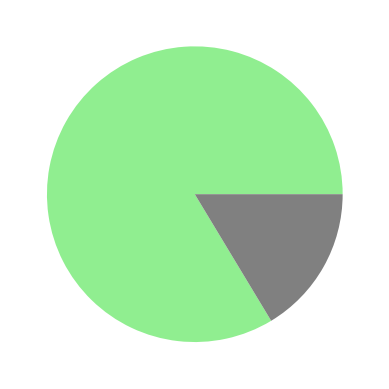

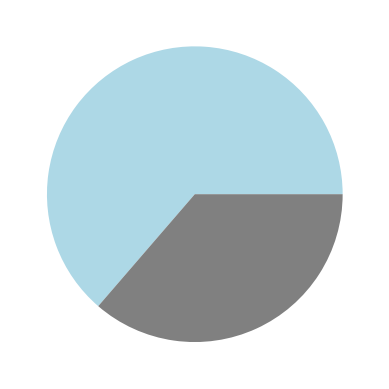

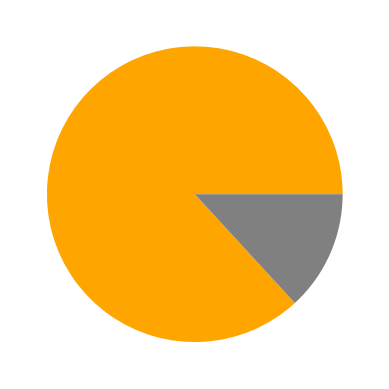

_______
Number of state neurons: 1287


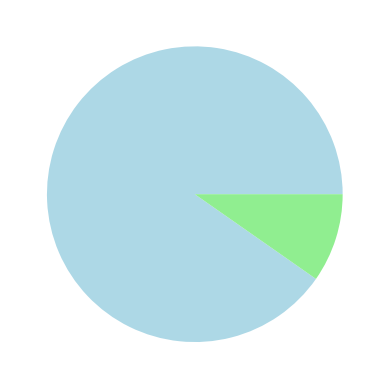

_______

99
Number of neurons: 2182
Number of phase neurons: 1701
Number of phase_state neurons: 746
Number of state neurons: 860
Proportion phase: 0.7795600366636114
(48.91428396522619, 0.0)
Proportion place: 0.7493125572868927
(47.15991553838689, 0.0)
Proportion state: 0.39413382218148485
(27.352720651593526, 0.0)
Proportion state of phase: 0.4385655496766608
(26.373961590614858, 0.0)
Proportion place of phase-state: 0.8337801608579088
(30.48117365696225, 0.0)
Proportion phase of state: 0.8674418604651163
(34.01779866033581, 0.0)


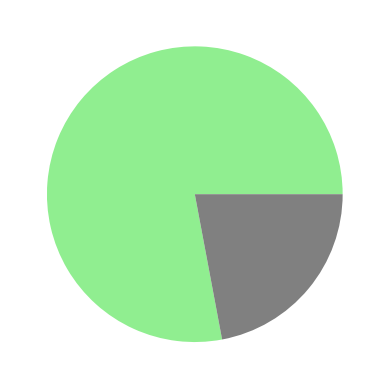

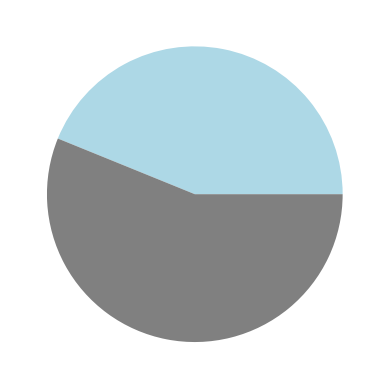

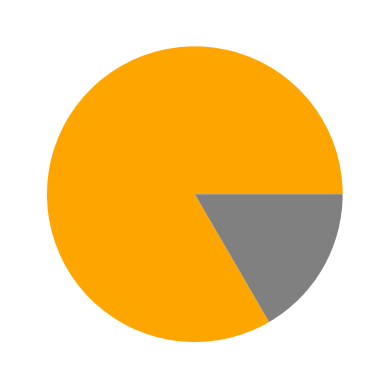

_______
Number of state neurons: 860


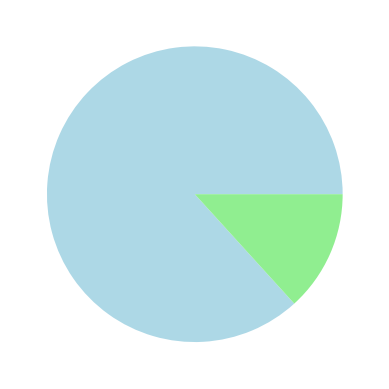

_______


In [94]:
###Plotting neuron proportions across single day
use_both=False
day_type='3_task_all'
for thr in [95,99]:
    print('')
    print(str(thr))
    percentile_neuron_bool_all=[]
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        
        mouse=mouse_recday.split('_',1)[0]
        cohort=Mice_cohort_dic[mouse]

        phase_bool1=Tuned_dic2['Phase'][str(thr)][mouse_recday]
        
        if len(phase_bool1)==0:
            continue
        place_bool1=Tuned_dic2['Place'][str(thr)][mouse_recday]
        state_bool=Tuned_dic2['State'][str(thr)][mouse_recday]
        
        phase_bool2=Phase_tuned_dic[mouse_recday]
        place_bool2=Place_tuned_dic[mouse_recday]
        
        if use_both==True:
            phase_bool=np.logical_and(phase_bool1,phase_bool2)
            place_bool=np.logical_and(place_bool1,place_bool2)
            
            Tuned_dic2['Phase_strict'][str(thr)][mouse_recday]=phase_bool
            Tuned_dic2['Place_strict'][str(thr)][mouse_recday]=place_bool
            
            
        else:
            phase_bool=phase_bool1
            place_bool=place_bool1
            
        
            
        percentile_neuron_bool=np.column_stack((phase_bool,place_bool,state_bool))

        percentile_neuron_bool_all.append(percentile_neuron_bool)

    percentile_neuron_bool_all=np.vstack((percentile_neuron_bool_all))

    prop_phase=np.sum(percentile_neuron_bool_all[:,0])/len(percentile_neuron_bool_all[:,0])
    prop_place=np.sum(percentile_neuron_bool_all[:,1])/len(percentile_neuron_bool_all[:,1])
    prop_state=np.sum(percentile_neuron_bool_all[:,2])/len(percentile_neuron_bool_all[:,2])
    
    phase_state_bool=np.logical_and(percentile_neuron_bool_all[:,0],percentile_neuron_bool_all[:,2])
    phase_state_place_bool=np.logical_and(phase_state_bool,percentile_neuron_bool_all[:,1])
    prop_state_of_phase=np.sum(phase_state_bool)/np.sum(percentile_neuron_bool_all[:,0])
    prop_place_of_phasestate=np.sum(phase_state_place_bool)/np.sum(phase_state_bool)
    prop_phase_of_state=np.sum(phase_state_bool)/np.sum(percentile_neuron_bool_all[:,2])
    
    print('Number of neurons: '+str(len(percentile_neuron_bool_all)))
    print('Number of phase neurons: '+str(np.sum(percentile_neuron_bool_all[:,0])))
    print('Number of phase_state neurons: '+str(np.sum(phase_state_bool)))
    print('Number of state neurons: '+str(np.sum(percentile_neuron_bool_all[:,2])))
    
    print('Proportion phase: '+str(prop_phase))
    print(two_proportions_test(np.sum(percentile_neuron_bool_all[:,0]), len(percentile_neuron_bool_all[:,0]),\
                           int(len(percentile_neuron_bool_all[:,0])*0.05), len(percentile_neuron_bool_all[:,0])))
    print('Proportion place: '+str(prop_place))
    print(two_proportions_test(np.sum(percentile_neuron_bool_all[:,1]), len(percentile_neuron_bool_all[:,1]),\
                           int(len(percentile_neuron_bool_all[:,1])*0.05), len(percentile_neuron_bool_all[:,1])))
    print('Proportion state: '+str(prop_state))
    print(two_proportions_test(np.sum(percentile_neuron_bool_all[:,2]), len(percentile_neuron_bool_all[:,2]),\
                           int(len(percentile_neuron_bool_all[:,2])*0.05), len(percentile_neuron_bool_all[:,2])))
    
    print('Proportion state of phase: '+str(prop_state_of_phase))
    print(two_proportions_test(np.sum(phase_state_bool), np.sum(percentile_neuron_bool_all[:,0]),\
                           int(np.sum(percentile_neuron_bool_all[:,0]))*0.05, np.sum(percentile_neuron_bool_all[:,0])))
    print('Proportion place of phase-state: '+str(prop_place_of_phasestate))
    print(two_proportions_test(np.sum(phase_state_place_bool), np.sum(phase_state_bool),\
                           int(np.sum(phase_state_bool))*0.05, np.sum(phase_state_bool)))
    
    print('Proportion phase of state: '+str(prop_phase_of_state))
    print(two_proportions_test(np.sum(phase_state_bool), np.sum(percentile_neuron_bool_all[:,2]),\
                           int(np.sum(percentile_neuron_bool_all[:,2]))*0.05, np.sum(percentile_neuron_bool_all[:,2])))
    
    vals=[np.sum(percentile_neuron_bool_all[:,0]), len(percentile_neuron_bool_all)-np.sum(percentile_neuron_bool_all[:,0])]
    colors=['lightgreen','grey']
    plt.pie(vals, colors=colors)
    plt.savefig(Output_folder+'All_phase_pie'+str(thr)+'.svg' , bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    vals=[np.sum(phase_state_bool), np.sum(percentile_neuron_bool_all[:,0])-np.sum(phase_state_bool)]
    colors=['lightblue','grey']
    plt.pie(vals, colors=colors)
    plt.savefig(Output_folder+'Phase_state_pie'+str(thr)+'.svg' , bbox_inches = 'tight', pad_inches = 0)
    plt.show()

    vals=[np.sum(phase_state_place_bool), np.sum(phase_state_bool)-np.sum(phase_state_place_bool)]
    colors=['orange','grey']
    plt.pie(vals, colors=colors)
    plt.savefig(Output_folder+'State_place_pie'+str(thr)+'.svg' , bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    print('_______')
    
    
    
    print('Number of state neurons: '+str(np.sum(percentile_neuron_bool_all[:,2])))
    vals=[np.sum(phase_state_bool), np.sum(percentile_neuron_bool_all[:,2])-np.sum(phase_state_bool)]
    colors=['lightblue','lightgreen']
    plt.pie(vals, colors=colors)
    plt.savefig(Output_folder+'State_phase_pie'+str(thr)+'.svg' , bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    print('_______')

In [95]:
for day_type in ['3_task_all','combined_ABCDonly']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        Goal_progress_strict=Tuned_dic2['Phase_strict']['95'][mouse_recday]
        Place_strict=Tuned_dic2['Place_strict']['95'][mouse_recday]
        State_strict=Tuned_dic['State_zmax_bool_strict'][mouse_recday]
        
        
        
        Place=Tuned_dic2['Place']['95'][mouse_recday]
        Goal_progress=Tuned_dic2['Phase']['95'][mouse_recday]
        State=Tuned_dic['State_zmax_bool'][mouse_recday]
        
        for measure, arrayX in {'Place':Place,'Goal_progress':Goal_progress,'State':State,\
                'Place_strict':Place_strict,'Goal_progress_strict':Goal_progress_strict,\
                                'State_strict':State_strict}.items():
            np.save(Input_folder+measure+'_'+mouse_recday+'.npy',arrayX)
        
        
        

In [96]:
print('phase cells: '+str(np.sum(phase_bool_all)/len(phase_bool_all)))
print('state cells: '+str(np.sum(state_bool_all)/len(state_bool_all)))
print('place cells: '+str(np.sum(place_bool_all)/len(place_bool_all)))

print('')

phase_state_bool=np.logical_and(phase_bool_all,state_bool_all)
print('state cells as proportion of phase cells: '+str(np.sum(phase_state_bool)/np.sum(phase_bool_all)))

phase_place_bool=np.logical_and(phase_bool_all,place_bool_all)

phase_state_unique=np.logical_and(phase_state_bool,~phase_place_bool)
phase_place_unique=np.logical_and(phase_place_bool,~phase_state_bool)

print('')

phase_place_and_state=np.logical_and(phase_place_bool,phase_state_bool)
print('place cells as proportion of phase/state cells: '+str(np.sum(phase_place_and_state)/np.sum(phase_state_bool)))

print(len(phase_bool_all))

phase cells: 0.8482428115015974
state cells: 0.5894568690095847
place cells: 0.8099041533546326

state cells as proportion of phase cells: 0.632768361581921

place cells as proportion of phase/state cells: 0.8601190476190477
1252


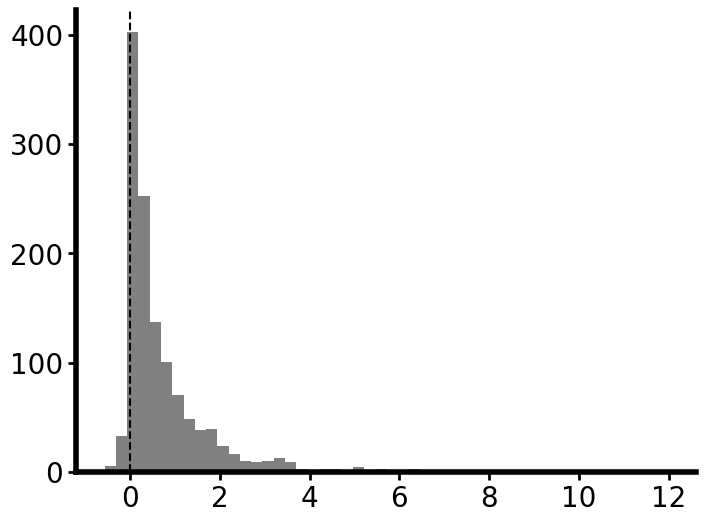

1252
TtestResult(statistic=22.51044659605891, pvalue=1.741187053117052e-94, df=1251)



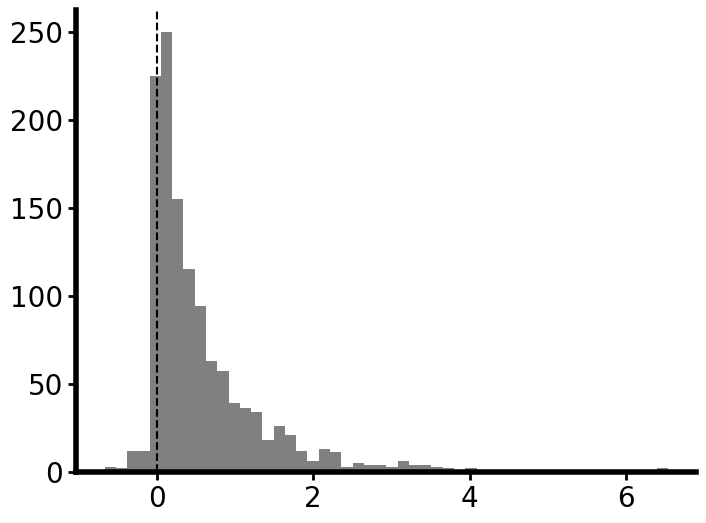

1252
TtestResult(statistic=25.912938200270325, pvalue=7.241292504850983e-119, df=1251)



In [98]:
day_type='combined_ABCDonly'

factor=40 ###because FR calculated in 25 ms bins 
phase_place_betas=np.vstack(([GLM_dic2['mean_neuron_betas'][mouse_recday] for mouse_recday\
                              in np.load(Input_folder+day_type+'_days.npy')]))
phase_betas=phase_place_betas[:,0]
place_betas=phase_place_betas[:,1]
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['axes.linewidth'] = 4
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.hist(phase_betas*factor,bins=50,color='grey')
plt.axvline(0,color='black',ls='dashed')
plt.tick_params(axis='both',  labelsize=20)
plt.tick_params(width=2, length=6)
plt.savefig(Output_folder+'Phase_betas.svg' , bbox_inches = 'tight', pad_inches = 0)
plt.show()
print(len(phase_betas))
print(st.ttest_1samp(phase_betas,0))
print('')

plt.hist(place_betas*factor,bins=50,color='grey')
plt.axvline(0,color='black',ls='dashed')
plt.tick_params(axis='both',  labelsize=20)
plt.tick_params(width=2, length=6)
plt.savefig(Output_folder+'Place_betas.svg' , bbox_inches = 'tight', pad_inches = 0)
plt.show()
print(len(place_betas))
print(st.ttest_1samp(place_betas,0))
print('')


Speed


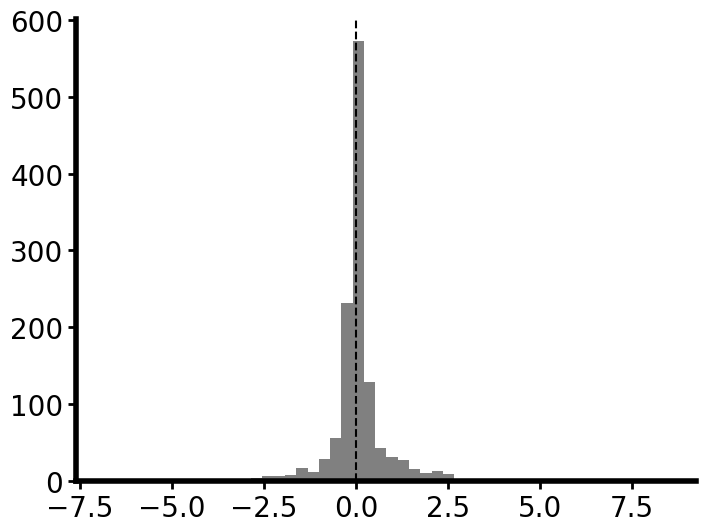

1252
TtestResult(statistic=3.479154882847542, pvalue=0.000520284452846498, df=1251)

Acceleration


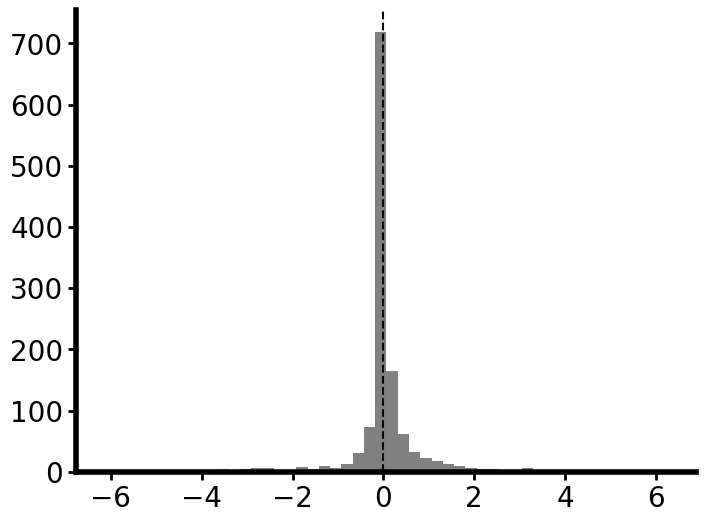

1252
TtestResult(statistic=-0.7712529260201972, pvalue=0.44070267431461463, df=1251)



In [100]:
day_type='combined_ABCDonly'
factor=40 ###because FR calculated in 25 ms bins 


print('Speed')
speed_betas=np.hstack(([np.nanmean(GLM_dic2['coeffs_all'][mouse_recday],axis=1)[:,4]\
for mouse_recday in np.load(Input_folder+day_type+'_days.npy')]))

plt.hist(speed_betas*factor,bins=50,color='grey')
plt.axvline(0,color='black',ls='dashed')
plt.tick_params(axis='both',  labelsize=20)
plt.tick_params(width=2, length=6)
plt.savefig(Output_folder+'Speed_betas.svg' , bbox_inches = 'tight', pad_inches = 0)
plt.show()
print(len(speed_betas))
print(st.ttest_1samp(speed_betas,0))
print('')

print('Acceleration')
acceleration_betas=np.hstack(([np.nanmean(GLM_dic2['coeffs_all'][mouse_recday],axis=1)[:,5]\
for mouse_recday in np.load(Input_folder+day_type+'_days.npy')]))

plt.hist(acceleration_betas*factor,bins=50,color='grey')
plt.axvline(0,color='black',ls='dashed')
plt.tick_params(axis='both',  labelsize=20)
plt.tick_params(width=2, length=6)
plt.savefig(Output_folder+'Acceleration_betas.svg' , bbox_inches = 'tight', pad_inches = 0)
plt.show()
print(len(acceleration_betas))
print(st.ttest_1samp(acceleration_betas,0))
print('')

In [104]:
###making arrays for split double days 
day_type='combined_ABCDonly'
for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
    print(mouse_recday)
    try:
        mouse=mouse_recday.split('_',1)[0]
        rec_day=mouse_recday.split('_',1)[1]
        rec_day1=rec_day.split('_',1)[0]
        rec_day2=rec_day.split('_',1)[1]
        Date1=rec_day1[-4:]+'-'+rec_day1[2:4]+'-'+rec_day1[:2]
        Date2=rec_day2[-4:]+'-'+rec_day2[2:4]+'-'+rec_day2[:2]

        mouse_recday1=mouse+'_'+rec_day1
        mouse_recday2=mouse+'_'+rec_day2

        num_neurons=len(np.load(Input_folder+'Neuron_raw_'+mouse_recday+'_0.npy'))

        for mouse_recdayX in [mouse_recday1,mouse_recday2]:
            day_typeX='3_task'
            if mouse_recdayX in np.load(Input_folder+day_typeX+'_days.npy'):
                continue
            
            
            for keyX in list(Tuned_dic.keys()):
                Tuned_dic[keyX][mouse_recdayX]=Tuned_dic[keyX][mouse_recday]
                
            for keyX in list(Tuned_dic2.keys()):
                for thr_X in Tuned_dic2[keyX].keys():
                    Tuned_dic2[keyX][thr_X][mouse_recdayX]=Tuned_dic2[keyX][thr_X][mouse_recday]
                
            for keyX in list(GLM_dic2.keys()):
                GLM_dic2[keyX][mouse_recdayX]=GLM_dic2[keyX][mouse_recday]
            
            for keyX in list(tuning_singletrial_dic2.keys()):
                tuning_singletrial_dic2[keyX][mouse_recdayX]=tuning_singletrial_dic2[keyX][mouse_recday]
                

            
    except Exception as e:
        print(e)

ab03_01092023_02092023
ab03_05092023_06092023
ab03_29082023_30082023
ah03_12082021_13082021
ah03_18082021_19082021
ah04_01122021_02122021
ah04_05122021_06122021
ah04_07122021_08122021
ah04_09122021_10122021
ah04_14122021_16122021
ah07_01092023_02092023
ah07_27082023_28082023
ah07_29082023_30082023
me08_06092021_09092021
me08_10092021_11092021
me08_12092021_13092021
me10_09122021_10122021
me10_14122021_15122021
me10_17122021_19122021
me10_20122021_21122021
me11_01122021_02122021
me11_05122021_06122021
me11_07122021_08122021
me11_09122021_10122021
me11_12122021_13122021


Phase
0.8482428115015974
(40.15247838340706, 0.0)
State
0.5894568690095847
(28.940904771885968, 0.0)
Phase_state
0.536741214057508
(26.747373281706665, 0.0)
Phase_state_place
0.46166134185303515
(23.605601090904205, 0.0)
Phase_state_noplace
0.07507987220447285
(2.591536806727433, 0.009554832011820391)

State cells as proportion of phase cells
1062
0.632768361581921
(28.320795708893847, 0.0)
Place cells as proportion of phase-state cells
672
0.8601190476190477
(29.820151442883763, 0.0)
Non place cells as proportion of phase-state cells
672
0.13988095238095238
(5.688297731879958, 1.2831197215845691e-08)
Phase-state cells as proportion of state cells
738
0.9105691056910569
(33.136226911015456, 0.0)


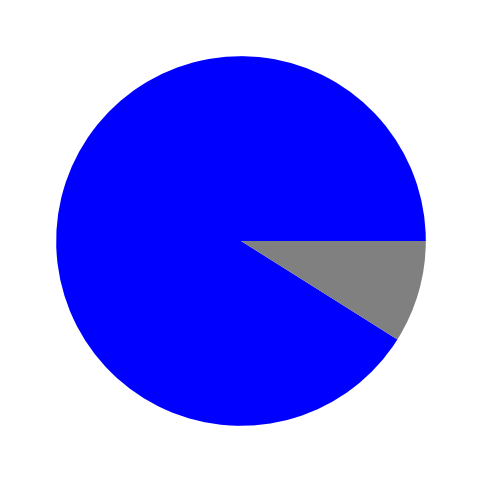

In [105]:
all_cells=np.arange(len(phase_bool_all))
phase_cells=np.where(phase_bool_all==True)[0]
state_cells=np.where(state_bool_all==True)[0]
place_cells=np.where(place_bool_all==True)[0]


non_phase_cells=np.where(phase_bool_all==False)[0]
non_state_cells=np.where(state_bool_all==False)[0]
non_place_cells=np.where(place_bool_all==False)[0]


phase_state_cells=np.intersect1d(phase_cells,state_cells)
phase_state_place_cells=np.intersect1d(phase_state_cells,place_cells)
phase_state_nonplace_cells=np.intersect1d(phase_state_cells,non_place_cells)

cell_type_dic={'Phase':phase_cells,'State':state_cells,'Phase_state':phase_state_cells,\
               'Phase_state_place':phase_state_place_cells,\
                    'Phase_state_noplace':phase_state_nonplace_cells}

for name, arrayX in cell_type_dic.items():
    print(name)
    print(len(arrayX)/len(all_cells))
    print(two_proportions_test(len(arrayX), len(all_cells), len(all_cells)*0.05, len(all_cells)))
print('')


print('State cells as proportion of phase cells')
print(len(phase_cells))
print(len(phase_state_cells)/len(phase_cells))
print(two_proportions_test(len(phase_state_cells), len(phase_cells), len(phase_cells)*0.05, len(phase_cells)))

print('Place cells as proportion of phase-state cells')
print(len(phase_state_cells))
print(len(phase_state_place_cells)/len(phase_state_cells))
print(two_proportions_test(len(phase_state_place_cells), len(phase_state_cells),\
                           len(phase_state_cells)*0.05, len(phase_state_cells)))

print('Non place cells as proportion of phase-state cells')
print(len(phase_state_cells))
print(len(phase_state_nonplace_cells)/len(phase_state_cells))
print(two_proportions_test(len(phase_state_nonplace_cells), len(phase_state_cells),\
                           int(len(phase_state_cells)*0.05), len(phase_state_cells)))
 
print('Phase-state cells as proportion of state cells')
print(len(state_cells))
print(len(phase_state_cells)/len(state_cells))
print(two_proportions_test(len(phase_state_cells), len(state_cells),\
                           int(len(state_cells)*0.05), len(state_cells)))

vals=[len(phase_state_cells), len(state_cells)-len(phase_state_cells)]
colors=['blue','grey']
plt.pie(vals, colors=colors)
plt.savefig(Output_folder+'state_phase_pie.svg' , bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [108]:
###Saving dictionary outputs as npy files     

for measure in Tuned_dic.keys():
    for mouse_recday in Tuned_dic[measure].keys():
        np.save(Input_folder+measure+'_'+mouse_recday+'.npy',\
               Tuned_dic[measure][mouse_recday])
        
for day_type in ['3_task','combined']:
    for mouse_recday in np.load(Input_folder+day_type+'_days.npy'):
        awake_sessions=np.load(Input_folder+'awake_session_behaviour_'+mouse_recday+'.npy')
        for ses_ind in np.arange(len(awake_sessions)):
            
            for name, dictionaryX in {'Phases_raw2_':Phases_raw_dic2, 'Phases_raw_':Phases_raw_dic,\
                                     'States_raw_':States_raw_dic,'Times_from_reward_':Times_from_reward_dic,\
                                     'Distances_from_reward_':Distances_from_reward_dic,\
                                     'Times_from_start_':Times_from_start_dic}.items():
                np.save(Input_folder+name+mouse_recday+'_'+str(ses_ind)+'.npy',\
                          dictionaryX[mouse_recday][ses_ind])
                
                        
for measure in tuning_singletrial_dic2.keys():
    for mouse_recday in tuning_singletrial_dic2[measure].keys():
        np.save(Input_folder+measure+'_'+mouse_recday+'.npy',\
               tuning_singletrial_dic2[measure][mouse_recday])    
        
for mouse_recday in speed_dic.keys():
    for ses_ind in speed_dic[mouse_recday].keys():
        np.save(Input_folder+'speed_'+mouse_recday+'_'+str(ses_ind)+'.npy',\
               speed_dic[mouse_recday][ses_ind])
        
        

C:\Users\moham\anaconda3\lib\site-packages\numpy\lib\npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)
